In [1]:
magnification_factor = ''
trainable_blocks = []
irun = 0

In [2]:
# Parameters
magnification_factor = "100X"
trainable_blocks = ["block1", "block2", "block3", "block4"]
irun = 4


In [3]:
irun = str(irun)

In [4]:
name = 'FINETUNING_'+ magnification_factor +'-BREAKHIS-Dataset-60-10-30-VGGINet'

path = './VGGINET-FT/%s/%s' % (name, irun)
!mkdir -p {path}

path

'./VGGINET-FT/FINETUNING_100X-BREAKHIS-Dataset-60-10-30-VGGINet/4'

In [5]:
tb_path = './tensorboard/' + magnification_factor + '/' + irun
tb_path

'./tensorboard/100X/4'

# Training

In [6]:
import tensorflow as tf
tf.version.VERSION, tf.config.list_physical_devices()

('2.3.0-rc1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
  PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
layer_name = 'block4_pool'
feature_ex_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output, name='vgg16_features')
feature_ex_model.trainable = False
feature_ex_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [9]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')

image_input = Input((224, 224, 3), name='Image_Input')
p1_tensor = p1_layer(image_input)

out =feature_ex_model(p1_tensor)
feature_ex_model = Model(inputs=image_input, outputs=out)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate,BatchNormalization,Activation 

def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate()([conv1, conv3, conv5, pool])
    return layer_out

In [11]:
out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
num_classes = 2

bn1 = BatchNormalization(name='BN')(out)
f = Flatten()(bn1)
dropout = Dropout(0.4, name='Dropout')(f)
desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

In [13]:
new_model = Model(inputs=feature_ex_model.input, outputs=desne)
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [14]:
from tensorflow import keras
opt = keras.optimizers.Adam(lr=0.001)

In [15]:
new_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    # ModelCheckpoint(monitor='val_accuracy',filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True)
]

In [17]:
from tensorflow.keras.callbacks import TensorBoard
callbacks += [TensorBoard(tb_path)]

In [18]:
import tensorflow as tf

image_size = (224, 340)
crop_size = (224, 224)
batch_size = 128

train_path = '../../Splitted_' + magnification_factor + '/train'
val_path = '../../Splitted_' + magnification_factor + '/val'
test_path = '../../Splitted_' + magnification_factor + '/test'

def dataset(ds_path, image_size, crop_size, batch_size, train):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels
    
    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=train)
        return cropped_images, labels
    
    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_ds = dataset(train_path, image_size, crop_size, batch_size, train=True)
val_ds = dataset(val_path, image_size, crop_size, batch_size, train=False)
test_ds = dataset(test_path, image_size, crop_size, batch_size, train=False)

Found 1128 files belonging to 2 classes.


Found 187 files belonging to 2 classes.


Found 566 files belonging to 2 classes.


In [19]:
init_epochs=100

In [20]:
train_history = new_model.fit(train_ds, epochs=init_epochs, 
                              validation_data=val_ds,
                              verbose=1, callbacks=callbacks)

Epoch 1/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0906 - accuracy: 0.5703

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2/9 [=====>........................] - ETA: 5s - loss: 1.9790 - accuracy: 0.6797

3/9 [=========>....................] - ETA: 9s - loss: 2.3665 - accuracy: 0.7083

4/9 [============>.................] - ETA: 7s - loss: 2.2068 - accuracy: 0.7441

5/9 [===============>..............] - ETA: 7s - loss: 2.5970 - accuracy: 0.7281

6/9 [===================>..........] - ETA: 5s - loss: 2.4783 - accuracy: 0.7461

7/9 [======================>.......] - ETA: 3s - loss: 2.6609 - accuracy: 0.7578

8/9 [=========================>....] - ETA: 1s - loss: 2.7649 - accuracy: 0.7637

9/9 [==============================] - ETA: 0s - loss: 2.8246 - accuracy: 0.7739

9/9 [==============================] - 29s 3s/step - loss: 2.8246 - accuracy: 0.7739 - val_loss: 4.6414 - val_accuracy: 0.8770


Epoch 2/100


1/9 [==>...........................] - ETA: 0s - loss: 1.5991 - accuracy: 0.8906

2/9 [=====>........................] - ETA: 13s - loss: 2.1053 - accuracy: 0.8633

3/9 [=========>....................] - ETA: 9s - loss: 2.2555 - accuracy: 0.8594 

4/9 [============>.................] - ETA: 10s - loss: 2.3761 - accuracy: 0.8418

5/9 [===============>..............] - ETA: 7s - loss: 2.2008 - accuracy: 0.8500 

6/9 [===================>..........] - ETA: 5s - loss: 2.1538 - accuracy: 0.8555

7/9 [======================>.......] - ETA: 3s - loss: 2.1199 - accuracy: 0.8527

8/9 [=========================>....] - ETA: 1s - loss: 2.0105 - accuracy: 0.8535

9/9 [==============================] - ETA: 0s - loss: 1.9280 - accuracy: 0.8582

9/9 [==============================] - 16s 2s/step - loss: 1.9280 - accuracy: 0.8582 - val_loss: 3.6482 - val_accuracy: 0.8930


Epoch 3/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7749 - accuracy: 0.9062

2/9 [=====>........................] - ETA: 13s - loss: 1.2598 - accuracy: 0.8945

3/9 [=========>....................] - ETA: 9s - loss: 1.0975 - accuracy: 0.9062 

4/9 [============>.................] - ETA: 10s - loss: 1.1370 - accuracy: 0.8984

5/9 [===============>..............] - ETA: 7s - loss: 1.2869 - accuracy: 0.8906 

6/9 [===================>..........] - ETA: 5s - loss: 1.3640 - accuracy: 0.8828

7/9 [======================>.......] - ETA: 3s - loss: 1.3568 - accuracy: 0.8828

8/9 [=========================>....] - ETA: 1s - loss: 1.3672 - accuracy: 0.8838

9/9 [==============================] - ETA: 0s - loss: 1.3271 - accuracy: 0.8856

9/9 [==============================] - 16s 2s/step - loss: 1.3271 - accuracy: 0.8856 - val_loss: 1.1196 - val_accuracy: 0.9305


Epoch 4/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7152 - accuracy: 0.8750

2/9 [=====>........................] - ETA: 13s - loss: 0.6612 - accuracy: 0.8984

3/9 [=========>....................] - ETA: 9s - loss: 0.8611 - accuracy: 0.9010 

4/9 [============>.................] - ETA: 9s - loss: 0.9200 - accuracy: 0.8965

5/9 [===============>..............] - ETA: 7s - loss: 0.8582 - accuracy: 0.9000

6/9 [===================>..........] - ETA: 4s - loss: 1.1408 - accuracy: 0.8867

7/9 [======================>.......] - ETA: 3s - loss: 1.1598 - accuracy: 0.8895

8/9 [=========================>....] - ETA: 1s - loss: 1.2222 - accuracy: 0.8916

9/9 [==============================] - ETA: 0s - loss: 1.1981 - accuracy: 0.8927

9/9 [==============================] - 16s 2s/step - loss: 1.1981 - accuracy: 0.8927 - val_loss: 1.0754 - val_accuracy: 0.9412


Epoch 5/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2446 - accuracy: 0.8906

2/9 [=====>........................] - ETA: 14s - loss: 1.4128 - accuracy: 0.8555

3/9 [=========>....................] - ETA: 9s - loss: 1.2234 - accuracy: 0.8646 

4/9 [============>.................] - ETA: 10s - loss: 0.9996 - accuracy: 0.8828

5/9 [===============>..............] - ETA: 7s - loss: 0.9924 - accuracy: 0.8828 

6/9 [===================>..........] - ETA: 5s - loss: 1.0506 - accuracy: 0.8841

7/9 [======================>.......] - ETA: 3s - loss: 1.2486 - accuracy: 0.8783

8/9 [=========================>....] - ETA: 1s - loss: 1.2837 - accuracy: 0.8818

9/9 [==============================] - ETA: 0s - loss: 1.2740 - accuracy: 0.8785

9/9 [==============================] - 17s 2s/step - loss: 1.2740 - accuracy: 0.8785 - val_loss: 1.0390 - val_accuracy: 0.9358


Epoch 6/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6759 - accuracy: 0.9062

2/9 [=====>........................] - ETA: 10s - loss: 0.6282 - accuracy: 0.9102

3/9 [=========>....................] - ETA: 8s - loss: 0.5094 - accuracy: 0.9297 

4/9 [============>.................] - ETA: 9s - loss: 0.5359 - accuracy: 0.9219

5/9 [===============>..............] - ETA: 7s - loss: 0.6289 - accuracy: 0.9234

6/9 [===================>..........] - ETA: 4s - loss: 0.7261 - accuracy: 0.9180

7/9 [======================>.......] - ETA: 3s - loss: 0.7376 - accuracy: 0.9152

8/9 [=========================>....] - ETA: 1s - loss: 0.7140 - accuracy: 0.9170

9/9 [==============================] - ETA: 0s - loss: 0.7384 - accuracy: 0.9176

9/9 [==============================] - 16s 2s/step - loss: 0.7384 - accuracy: 0.9176 - val_loss: 1.9459 - val_accuracy: 0.8824


Epoch 7/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1628 - accuracy: 0.9062

2/9 [=====>........................] - ETA: 14s - loss: 1.0600 - accuracy: 0.9062

3/9 [=========>....................] - ETA: 10s - loss: 1.1682 - accuracy: 0.8880

4/9 [============>.................] - ETA: 9s - loss: 1.2461 - accuracy: 0.8828 

5/9 [===============>..............] - ETA: 7s - loss: 1.3120 - accuracy: 0.8813

6/9 [===================>..........] - ETA: 5s - loss: 1.3336 - accuracy: 0.8828

7/9 [======================>.......] - ETA: 3s - loss: 1.3522 - accuracy: 0.8862

8/9 [=========================>....] - ETA: 1s - loss: 1.3270 - accuracy: 0.8916

9/9 [==============================] - ETA: 0s - loss: 1.3030 - accuracy: 0.8918

9/9 [==============================] - 16s 2s/step - loss: 1.3030 - accuracy: 0.8918 - val_loss: 1.1842 - val_accuracy: 0.9305


Epoch 8/100


1/9 [==>...........................] - ETA: 0s - loss: 1.3274 - accuracy: 0.8672

2/9 [=====>........................] - ETA: 14s - loss: 1.2175 - accuracy: 0.8828

3/9 [=========>....................] - ETA: 9s - loss: 1.1913 - accuracy: 0.8958 

4/9 [============>.................] - ETA: 9s - loss: 1.1332 - accuracy: 0.9043

5/9 [===============>..............] - ETA: 7s - loss: 1.1380 - accuracy: 0.9000

6/9 [===================>..........] - ETA: 5s - loss: 1.0411 - accuracy: 0.9062

7/9 [======================>.......] - ETA: 3s - loss: 1.0892 - accuracy: 0.9118

8/9 [=========================>....] - ETA: 1s - loss: 1.0631 - accuracy: 0.9121

9/9 [==============================] - ETA: 0s - loss: 1.0679 - accuracy: 0.9105

9/9 [==============================] - 16s 2s/step - loss: 1.0679 - accuracy: 0.9105 - val_loss: 1.2870 - val_accuracy: 0.9305


Epoch 9/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5999 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 13s - loss: 1.0988 - accuracy: 0.8945

3/9 [=========>....................] - ETA: 9s - loss: 1.1015 - accuracy: 0.8906 

4/9 [============>.................] - ETA: 9s - loss: 1.0775 - accuracy: 0.8945

5/9 [===============>..............] - ETA: 7s - loss: 1.1764 - accuracy: 0.8953

6/9 [===================>..........] - ETA: 4s - loss: 1.0825 - accuracy: 0.9023

7/9 [======================>.......] - ETA: 3s - loss: 1.1565 - accuracy: 0.8973

8/9 [=========================>....] - ETA: 1s - loss: 1.1811 - accuracy: 0.8955

9/9 [==============================] - ETA: 0s - loss: 1.1102 - accuracy: 0.9007

9/9 [==============================] - 16s 2s/step - loss: 1.1102 - accuracy: 0.9007 - val_loss: 1.2948 - val_accuracy: 0.9251


Epoch 10/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7190 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 14s - loss: 0.7207 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 11s - loss: 0.7548 - accuracy: 0.9271

4/9 [============>.................] - ETA: 9s - loss: 0.7213 - accuracy: 0.9336 

5/9 [===============>..............] - ETA: 7s - loss: 0.7532 - accuracy: 0.9344

6/9 [===================>..........] - ETA: 5s - loss: 0.7117 - accuracy: 0.9362

7/9 [======================>.......] - ETA: 3s - loss: 0.7676 - accuracy: 0.9286

8/9 [=========================>....] - ETA: 1s - loss: 0.7751 - accuracy: 0.9277

9/9 [==============================] - ETA: 0s - loss: 0.7636 - accuracy: 0.9273

9/9 [==============================] - 17s 2s/step - loss: 0.7636 - accuracy: 0.9273 - val_loss: 0.8666 - val_accuracy: 0.9305


Epoch 11/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5401 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.5195 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 9s - loss: 0.5673 - accuracy: 0.9245 

4/9 [============>.................] - ETA: 9s - loss: 0.5150 - accuracy: 0.9277

5/9 [===============>..............] - ETA: 7s - loss: 0.5687 - accuracy: 0.9250

6/9 [===================>..........] - ETA: 4s - loss: 0.6882 - accuracy: 0.9232

7/9 [======================>.......] - ETA: 3s - loss: 0.7274 - accuracy: 0.9241

8/9 [=========================>....] - ETA: 1s - loss: 0.7327 - accuracy: 0.9248

9/9 [==============================] - ETA: 0s - loss: 0.7143 - accuracy: 0.9255

9/9 [==============================] - 16s 2s/step - loss: 0.7143 - accuracy: 0.9255 - val_loss: 1.2738 - val_accuracy: 0.9251


Epoch 12/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9267 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 14s - loss: 1.1298 - accuracy: 0.8945

3/9 [=========>....................] - ETA: 9s - loss: 0.8331 - accuracy: 0.9115 

4/9 [============>.................] - ETA: 9s - loss: 0.8438 - accuracy: 0.9043

5/9 [===============>..............] - ETA: 7s - loss: 0.8303 - accuracy: 0.9062

6/9 [===================>..........] - ETA: 5s - loss: 0.8139 - accuracy: 0.9076

7/9 [======================>.......] - ETA: 3s - loss: 0.8068 - accuracy: 0.9129

8/9 [=========================>....] - ETA: 1s - loss: 0.8195 - accuracy: 0.9121

9/9 [==============================] - ETA: 0s - loss: 0.7743 - accuracy: 0.9167

9/9 [==============================] - 17s 2s/step - loss: 0.7743 - accuracy: 0.9167 - val_loss: 0.4656 - val_accuracy: 0.9519


Epoch 13/100


1/9 [==>...........................] - ETA: 0s - loss: 2.4400 - accuracy: 0.8594

2/9 [=====>........................] - ETA: 13s - loss: 1.7744 - accuracy: 0.8711

3/9 [=========>....................] - ETA: 9s - loss: 1.3550 - accuracy: 0.8984 

4/9 [============>.................] - ETA: 9s - loss: 1.2052 - accuracy: 0.9102

5/9 [===============>..............] - ETA: 7s - loss: 1.1644 - accuracy: 0.9094

6/9 [===================>..........] - ETA: 5s - loss: 1.1090 - accuracy: 0.9102

7/9 [======================>.......] - ETA: 3s - loss: 1.0448 - accuracy: 0.9118

8/9 [=========================>....] - ETA: 1s - loss: 1.0713 - accuracy: 0.9111

9/9 [==============================] - ETA: 0s - loss: 1.0302 - accuracy: 0.9122

9/9 [==============================] - 16s 2s/step - loss: 1.0302 - accuracy: 0.9122 - val_loss: 0.7615 - val_accuracy: 0.9412


Epoch 14/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7011 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 3s - loss: 0.5468 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 7s - loss: 0.6889 - accuracy: 0.9297

4/9 [============>.................] - ETA: 6s - loss: 0.7351 - accuracy: 0.9297

5/9 [===============>..............] - ETA: 6s - loss: 0.8317 - accuracy: 0.9297

6/9 [===================>..........] - ETA: 5s - loss: 0.9303 - accuracy: 0.9284

7/9 [======================>.......] - ETA: 3s - loss: 0.9945 - accuracy: 0.9230

8/9 [=========================>....] - ETA: 1s - loss: 0.9903 - accuracy: 0.9258

9/9 [==============================] - ETA: 0s - loss: 1.0003 - accuracy: 0.9238

9/9 [==============================] - 16s 2s/step - loss: 1.0003 - accuracy: 0.9238 - val_loss: 0.6002 - val_accuracy: 0.9465


Epoch 15/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5976 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 1.0185 - accuracy: 0.9219

3/9 [=========>....................] - ETA: 10s - loss: 0.9150 - accuracy: 0.9193

4/9 [============>.................] - ETA: 10s - loss: 0.9100 - accuracy: 0.9238

5/9 [===============>..............] - ETA: 7s - loss: 1.0158 - accuracy: 0.9187 

6/9 [===================>..........] - ETA: 5s - loss: 1.0088 - accuracy: 0.9206

7/9 [======================>.......] - ETA: 3s - loss: 1.0534 - accuracy: 0.9196

8/9 [=========================>....] - ETA: 1s - loss: 1.0287 - accuracy: 0.9189

9/9 [==============================] - ETA: 0s - loss: 1.0548 - accuracy: 0.9158

9/9 [==============================] - 17s 2s/step - loss: 1.0548 - accuracy: 0.9158 - val_loss: 1.0862 - val_accuracy: 0.9519


Epoch 16/100


1/9 [==>...........................] - ETA: 0s - loss: 2.1152 - accuracy: 0.8359

2/9 [=====>........................] - ETA: 13s - loss: 1.2767 - accuracy: 0.8750

3/9 [=========>....................] - ETA: 9s - loss: 1.6260 - accuracy: 0.8724 

4/9 [============>.................] - ETA: 9s - loss: 1.4057 - accuracy: 0.8906

5/9 [===============>..............] - ETA: 7s - loss: 1.4917 - accuracy: 0.8938

6/9 [===================>..........] - ETA: 5s - loss: 1.3114 - accuracy: 0.9049

7/9 [======================>.......] - ETA: 3s - loss: 1.3520 - accuracy: 0.9074

8/9 [=========================>....] - ETA: 1s - loss: 1.3730 - accuracy: 0.9043

9/9 [==============================] - ETA: 0s - loss: 1.3020 - accuracy: 0.9051

9/9 [==============================] - 16s 2s/step - loss: 1.3020 - accuracy: 0.9051 - val_loss: 0.4011 - val_accuracy: 0.9626


Epoch 17/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6284 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 14s - loss: 0.9293 - accuracy: 0.9180

3/9 [=========>....................] - ETA: 9s - loss: 0.7204 - accuracy: 0.9323 

4/9 [============>.................] - ETA: 9s - loss: 0.7179 - accuracy: 0.9336

5/9 [===============>..............] - ETA: 7s - loss: 0.7334 - accuracy: 0.9359

6/9 [===================>..........] - ETA: 4s - loss: 0.6894 - accuracy: 0.9375

7/9 [======================>.......] - ETA: 3s - loss: 0.6898 - accuracy: 0.9319

8/9 [=========================>....] - ETA: 1s - loss: 0.6967 - accuracy: 0.9316

9/9 [==============================] - ETA: 0s - loss: 0.7043 - accuracy: 0.9317

9/9 [==============================] - 16s 2s/step - loss: 0.7043 - accuracy: 0.9317 - val_loss: 1.3167 - val_accuracy: 0.9198


Epoch 18/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5029 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.7916 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 9s - loss: 0.7005 - accuracy: 0.9401 

4/9 [============>.................] - ETA: 9s - loss: 0.6870 - accuracy: 0.9395

5/9 [===============>..............] - ETA: 7s - loss: 0.6192 - accuracy: 0.9453

6/9 [===================>..........] - ETA: 4s - loss: 0.5920 - accuracy: 0.9453

7/9 [======================>.......] - ETA: 3s - loss: 0.6860 - accuracy: 0.9442

8/9 [=========================>....] - ETA: 1s - loss: 0.6745 - accuracy: 0.9424

9/9 [==============================] - ETA: 0s - loss: 0.6676 - accuracy: 0.9433

9/9 [==============================] - 16s 2s/step - loss: 0.6676 - accuracy: 0.9433 - val_loss: 0.4923 - val_accuracy: 0.9465


Epoch 19/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3670 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.8565 - accuracy: 0.9141

3/9 [=========>....................] - ETA: 9s - loss: 0.8183 - accuracy: 0.9219 

4/9 [============>.................] - ETA: 9s - loss: 0.7437 - accuracy: 0.9336

5/9 [===============>..............] - ETA: 7s - loss: 0.7566 - accuracy: 0.9391

6/9 [===================>..........] - ETA: 4s - loss: 0.7231 - accuracy: 0.9414

7/9 [======================>.......] - ETA: 3s - loss: 0.7845 - accuracy: 0.9364

8/9 [=========================>....] - ETA: 1s - loss: 0.7554 - accuracy: 0.9385

9/9 [==============================] - ETA: 0s - loss: 0.8569 - accuracy: 0.9317

9/9 [==============================] - 16s 2s/step - loss: 0.8569 - accuracy: 0.9317 - val_loss: 1.0341 - val_accuracy: 0.9037


Epoch 20/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4956 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 3s - loss: 0.3852 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 7s - loss: 0.4624 - accuracy: 0.9219

4/9 [============>.................] - ETA: 6s - loss: 0.4780 - accuracy: 0.9238

5/9 [===============>..............] - ETA: 6s - loss: 0.5724 - accuracy: 0.9203

6/9 [===================>..........] - ETA: 4s - loss: 0.6497 - accuracy: 0.9219

7/9 [======================>.......] - ETA: 3s - loss: 0.6969 - accuracy: 0.9230

8/9 [=========================>....] - ETA: 1s - loss: 0.7256 - accuracy: 0.9258

9/9 [==============================] - ETA: 0s - loss: 0.7578 - accuracy: 0.9238

9/9 [==============================] - 16s 2s/step - loss: 0.7578 - accuracy: 0.9238 - val_loss: 1.4927 - val_accuracy: 0.9144


Epoch 21/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6066 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 1.4384 - accuracy: 0.9258

3/9 [=========>....................] - ETA: 10s - loss: 1.0900 - accuracy: 0.9375

4/9 [============>.................] - ETA: 10s - loss: 0.9379 - accuracy: 0.9434

5/9 [===============>..............] - ETA: 7s - loss: 0.9855 - accuracy: 0.9406 

6/9 [===================>..........] - ETA: 5s - loss: 0.9572 - accuracy: 0.9401

7/9 [======================>.......] - ETA: 3s - loss: 0.8234 - accuracy: 0.9475

8/9 [=========================>....] - ETA: 1s - loss: 0.9434 - accuracy: 0.9414

9/9 [==============================] - ETA: 0s - loss: 0.8869 - accuracy: 0.9415

9/9 [==============================] - 17s 2s/step - loss: 0.8869 - accuracy: 0.9415 - val_loss: 0.6651 - val_accuracy: 0.9519


Epoch 22/100


1/9 [==>...........................] - ETA: 0s - loss: 1.7206 - accuracy: 0.9062

2/9 [=====>........................] - ETA: 13s - loss: 1.4395 - accuracy: 0.9102

3/9 [=========>....................] - ETA: 9s - loss: 1.1048 - accuracy: 0.9323 

4/9 [============>.................] - ETA: 10s - loss: 1.0072 - accuracy: 0.9316

5/9 [===============>..............] - ETA: 7s - loss: 0.9712 - accuracy: 0.9266 

6/9 [===================>..........] - ETA: 5s - loss: 1.0564 - accuracy: 0.9219

7/9 [======================>.......] - ETA: 3s - loss: 0.9251 - accuracy: 0.9286

8/9 [=========================>....] - ETA: 1s - loss: 0.8732 - accuracy: 0.9316

9/9 [==============================] - ETA: 0s - loss: 0.8206 - accuracy: 0.9353

9/9 [==============================] - 16s 2s/step - loss: 0.8206 - accuracy: 0.9353 - val_loss: 0.6479 - val_accuracy: 0.9572


Epoch 23/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2201 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.3255 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.7846 - accuracy: 0.9505

4/9 [============>.................] - ETA: 9s - loss: 0.7481 - accuracy: 0.9434 

5/9 [===============>..............] - ETA: 7s - loss: 0.6088 - accuracy: 0.9531

6/9 [===================>..........] - ETA: 5s - loss: 0.6786 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 3s - loss: 0.6132 - accuracy: 0.9531

8/9 [=========================>....] - ETA: 1s - loss: 0.6067 - accuracy: 0.9551

9/9 [==============================] - ETA: 0s - loss: 0.5623 - accuracy: 0.9574

9/9 [==============================] - 16s 2s/step - loss: 0.5623 - accuracy: 0.9574 - val_loss: 0.7689 - val_accuracy: 0.9465


Epoch 24/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8192 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 3s - loss: 0.7382 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 9s - loss: 0.6336 - accuracy: 0.9401

4/9 [============>.................] - ETA: 9s - loss: 0.6466 - accuracy: 0.9434

5/9 [===============>..............] - ETA: 7s - loss: 0.6982 - accuracy: 0.9406

6/9 [===================>..........] - ETA: 4s - loss: 0.7520 - accuracy: 0.9362

7/9 [======================>.......] - ETA: 3s - loss: 0.7414 - accuracy: 0.9364

8/9 [=========================>....] - ETA: 1s - loss: 0.7498 - accuracy: 0.9355

9/9 [==============================] - ETA: 0s - loss: 0.7468 - accuracy: 0.9362

9/9 [==============================] - 16s 2s/step - loss: 0.7468 - accuracy: 0.9362 - val_loss: 1.1083 - val_accuracy: 0.9465


Epoch 25/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4354 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 13s - loss: 0.4940 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 9s - loss: 0.4447 - accuracy: 0.9349 

4/9 [============>.................] - ETA: 10s - loss: 0.3956 - accuracy: 0.9414

5/9 [===============>..............] - ETA: 7s - loss: 0.4994 - accuracy: 0.9438 

6/9 [===================>..........] - ETA: 5s - loss: 0.5598 - accuracy: 0.9401

7/9 [======================>.......] - ETA: 3s - loss: 0.5600 - accuracy: 0.9420

8/9 [=========================>....] - ETA: 1s - loss: 0.6189 - accuracy: 0.9414

9/9 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.9379

9/9 [==============================] - 16s 2s/step - loss: 0.6918 - accuracy: 0.9379 - val_loss: 0.6550 - val_accuracy: 0.9465


Epoch 26/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7293 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.7109 - accuracy: 0.9297

3/9 [=========>....................] - ETA: 9s - loss: 0.6889 - accuracy: 0.9375 

4/9 [============>.................] - ETA: 9s - loss: 0.6218 - accuracy: 0.9434

5/9 [===============>..............] - ETA: 7s - loss: 0.6152 - accuracy: 0.9469

6/9 [===================>..........] - ETA: 4s - loss: 0.5778 - accuracy: 0.9492

7/9 [======================>.......] - ETA: 3s - loss: 0.6314 - accuracy: 0.9453

8/9 [=========================>....] - ETA: 1s - loss: 0.6602 - accuracy: 0.9424

9/9 [==============================] - ETA: 0s - loss: 0.6771 - accuracy: 0.9433

9/9 [==============================] - 16s 2s/step - loss: 0.6771 - accuracy: 0.9433 - val_loss: 0.9895 - val_accuracy: 0.9465


Epoch 27/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5143 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 3s - loss: 0.7923 - accuracy: 0.9219

3/9 [=========>....................] - ETA: 8s - loss: 0.7142 - accuracy: 0.9323

4/9 [============>.................] - ETA: 6s - loss: 0.7354 - accuracy: 0.9316

5/9 [===============>..............] - ETA: 6s - loss: 0.6153 - accuracy: 0.9391

6/9 [===================>..........] - ETA: 4s - loss: 0.6769 - accuracy: 0.9388

7/9 [======================>.......] - ETA: 2s - loss: 0.6446 - accuracy: 0.9397

8/9 [=========================>....] - ETA: 1s - loss: 0.6751 - accuracy: 0.9395

9/9 [==============================] - ETA: 0s - loss: 0.6440 - accuracy: 0.9397

9/9 [==============================] - 15s 2s/step - loss: 0.6440 - accuracy: 0.9397 - val_loss: 0.8488 - val_accuracy: 0.9519


Epoch 28/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2596 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.3825 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.4684 - accuracy: 0.9609 

4/9 [============>.................] - ETA: 9s - loss: 0.5253 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 7s - loss: 0.4578 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 4s - loss: 0.4933 - accuracy: 0.9635

7/9 [======================>.......] - ETA: 3s - loss: 0.4731 - accuracy: 0.9621

8/9 [=========================>....] - ETA: 1s - loss: 0.4975 - accuracy: 0.9600

9/9 [==============================] - ETA: 0s - loss: 0.5165 - accuracy: 0.9574

9/9 [==============================] - 16s 2s/step - loss: 0.5165 - accuracy: 0.9574 - val_loss: 1.0136 - val_accuracy: 0.9465


Epoch 29/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2806 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 0.8843 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 9s - loss: 0.7750 - accuracy: 0.9427 

4/9 [============>.................] - ETA: 9s - loss: 0.6508 - accuracy: 0.9492

5/9 [===============>..............] - ETA: 7s - loss: 0.7257 - accuracy: 0.9469

6/9 [===================>..........] - ETA: 4s - loss: 0.8133 - accuracy: 0.9440

7/9 [======================>.......] - ETA: 3s - loss: 0.7837 - accuracy: 0.9453

8/9 [=========================>....] - ETA: 1s - loss: 0.8710 - accuracy: 0.9395

9/9 [==============================] - ETA: 0s - loss: 0.8156 - accuracy: 0.9424

9/9 [==============================] - 16s 2s/step - loss: 0.8156 - accuracy: 0.9424 - val_loss: 1.1552 - val_accuracy: 0.9572


Epoch 30/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1221 - accuracy: 0.9141

2/9 [=====>........................] - ETA: 13s - loss: 1.0299 - accuracy: 0.9219

3/9 [=========>....................] - ETA: 9s - loss: 0.7902 - accuracy: 0.9349 

4/9 [============>.................] - ETA: 9s - loss: 0.9880 - accuracy: 0.9238

5/9 [===============>..............] - ETA: 7s - loss: 0.8647 - accuracy: 0.9328

6/9 [===================>..........] - ETA: 4s - loss: 0.7862 - accuracy: 0.9362

7/9 [======================>.......] - ETA: 3s - loss: 0.6775 - accuracy: 0.9431

8/9 [=========================>....] - ETA: 1s - loss: 0.6776 - accuracy: 0.9434

9/9 [==============================] - ETA: 0s - loss: 0.7378 - accuracy: 0.9397

9/9 [==============================] - 16s 2s/step - loss: 0.7378 - accuracy: 0.9397 - val_loss: 1.3906 - val_accuracy: 0.9358


Epoch 31/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9751 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 3s - loss: 0.7811 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.7653 - accuracy: 0.9427

4/9 [============>.................] - ETA: 9s - loss: 0.7296 - accuracy: 0.9414

5/9 [===============>..............] - ETA: 7s - loss: 0.6751 - accuracy: 0.9453

6/9 [===================>..........] - ETA: 5s - loss: 0.5899 - accuracy: 0.9518

7/9 [======================>.......] - ETA: 3s - loss: 0.5922 - accuracy: 0.9531

8/9 [=========================>....] - ETA: 1s - loss: 0.5719 - accuracy: 0.9551

9/9 [==============================] - ETA: 0s - loss: 0.5744 - accuracy: 0.9557

9/9 [==============================] - 17s 2s/step - loss: 0.5744 - accuracy: 0.9557 - val_loss: 1.3363 - val_accuracy: 0.9412


Epoch 32/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5024 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 3s - loss: 0.6375 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 9s - loss: 0.7411 - accuracy: 0.9453

4/9 [============>.................] - ETA: 9s - loss: 0.7001 - accuracy: 0.9512

5/9 [===============>..............] - ETA: 7s - loss: 0.6545 - accuracy: 0.9547

6/9 [===================>..........] - ETA: 4s - loss: 0.7119 - accuracy: 0.9492

7/9 [======================>.......] - ETA: 3s - loss: 0.6536 - accuracy: 0.9509

8/9 [=========================>....] - ETA: 1s - loss: 0.7218 - accuracy: 0.9521

9/9 [==============================] - ETA: 0s - loss: 0.7231 - accuracy: 0.9504

9/9 [==============================] - 16s 2s/step - loss: 0.7231 - accuracy: 0.9504 - val_loss: 0.7963 - val_accuracy: 0.9465


Epoch 33/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4099 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.6966 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 9s - loss: 0.5287 - accuracy: 0.9505 

4/9 [============>.................] - ETA: 9s - loss: 0.4660 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 7s - loss: 0.4213 - accuracy: 0.9594

6/9 [===================>..........] - ETA: 4s - loss: 0.4703 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.4381 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.5044 - accuracy: 0.9570

9/9 [==============================] - ETA: 0s - loss: 0.4791 - accuracy: 0.9574

9/9 [==============================] - 16s 2s/step - loss: 0.4791 - accuracy: 0.9574 - val_loss: 0.6963 - val_accuracy: 0.9519


Epoch 34/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5563 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 15s - loss: 0.6296 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 10s - loss: 0.4834 - accuracy: 0.9583

4/9 [============>.................] - ETA: 10s - loss: 0.5254 - accuracy: 0.9512

5/9 [===============>..............] - ETA: 8s - loss: 0.5547 - accuracy: 0.9484 

6/9 [===================>..........] - ETA: 5s - loss: 0.7071 - accuracy: 0.9427

7/9 [======================>.......] - ETA: 3s - loss: 0.6898 - accuracy: 0.9431

8/9 [=========================>....] - ETA: 1s - loss: 0.6715 - accuracy: 0.9434

9/9 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.9424

9/9 [==============================] - 17s 2s/step - loss: 0.6909 - accuracy: 0.9424 - val_loss: 0.3942 - val_accuracy: 0.9626


Epoch 35/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9258 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.7672 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 10s - loss: 0.6276 - accuracy: 0.9531

4/9 [============>.................] - ETA: 10s - loss: 0.6535 - accuracy: 0.9453

5/9 [===============>..............] - ETA: 7s - loss: 0.7502 - accuracy: 0.9422 

6/9 [===================>..........] - ETA: 5s - loss: 0.7340 - accuracy: 0.9453

7/9 [======================>.......] - ETA: 3s - loss: 0.7322 - accuracy: 0.9453

8/9 [=========================>....] - ETA: 1s - loss: 0.7284 - accuracy: 0.9453

9/9 [==============================] - ETA: 0s - loss: 0.7058 - accuracy: 0.9424

9/9 [==============================] - 17s 2s/step - loss: 0.7058 - accuracy: 0.9424 - val_loss: 1.1596 - val_accuracy: 0.9412


Epoch 36/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7098 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.5331 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.4558 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 11s - loss: 0.5153 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 7s - loss: 0.4539 - accuracy: 0.9609 

6/9 [===================>..........] - ETA: 5s - loss: 0.4318 - accuracy: 0.9635

7/9 [======================>.......] - ETA: 3s - loss: 0.3870 - accuracy: 0.9654

8/9 [=========================>....] - ETA: 1s - loss: 0.4176 - accuracy: 0.9619

9/9 [==============================] - ETA: 0s - loss: 0.4264 - accuracy: 0.9610

9/9 [==============================] - 17s 2s/step - loss: 0.4264 - accuracy: 0.9610 - val_loss: 0.6826 - val_accuracy: 0.9733


Epoch 37/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7148 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 14s - loss: 0.9912 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 10s - loss: 0.8483 - accuracy: 0.9453

4/9 [============>.................] - ETA: 10s - loss: 0.6740 - accuracy: 0.9512

5/9 [===============>..............] - ETA: 7s - loss: 0.5493 - accuracy: 0.9578 

6/9 [===================>..........] - ETA: 5s - loss: 0.5151 - accuracy: 0.9596

7/9 [======================>.......] - ETA: 3s - loss: 0.4889 - accuracy: 0.9609

8/9 [=========================>....] - ETA: 1s - loss: 0.5034 - accuracy: 0.9570

9/9 [==============================] - ETA: 0s - loss: 0.4989 - accuracy: 0.9557

9/9 [==============================] - 17s 2s/step - loss: 0.4989 - accuracy: 0.9557 - val_loss: 0.3566 - val_accuracy: 0.9733


Epoch 38/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4874 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.3156 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.4036 - accuracy: 0.9557

4/9 [============>.................] - ETA: 10s - loss: 0.5185 - accuracy: 0.9492

5/9 [===============>..............] - ETA: 7s - loss: 0.4336 - accuracy: 0.9563 

6/9 [===================>..........] - ETA: 5s - loss: 0.4384 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.4593 - accuracy: 0.9576

8/9 [=========================>....] - ETA: 1s - loss: 0.5707 - accuracy: 0.9561

9/9 [==============================] - ETA: 0s - loss: 0.5815 - accuracy: 0.9566

9/9 [==============================] - 16s 2s/step - loss: 0.5815 - accuracy: 0.9566 - val_loss: 0.5511 - val_accuracy: 0.9626


Epoch 39/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5865 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.4300 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 10s - loss: 0.5303 - accuracy: 0.9531

4/9 [============>.................] - ETA: 10s - loss: 0.5769 - accuracy: 0.9531

5/9 [===============>..............] - ETA: 7s - loss: 0.4814 - accuracy: 0.9609 

6/9 [===================>..........] - ETA: 5s - loss: 0.4547 - accuracy: 0.9622

7/9 [======================>.......] - ETA: 3s - loss: 0.4850 - accuracy: 0.9609

8/9 [=========================>....] - ETA: 1s - loss: 0.5128 - accuracy: 0.9590

9/9 [==============================] - ETA: 0s - loss: 0.5137 - accuracy: 0.9592

9/9 [==============================] - 16s 2s/step - loss: 0.5137 - accuracy: 0.9592 - val_loss: 0.8616 - val_accuracy: 0.9519


Epoch 40/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8504 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 11s - loss: 0.5582 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 14s - loss: 0.4239 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.4767 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 9s - loss: 0.4220 - accuracy: 0.9641 

6/9 [===================>..........] - ETA: 6s - loss: 0.4343 - accuracy: 0.9609

7/9 [======================>.......] - ETA: 3s - loss: 0.4034 - accuracy: 0.9609

8/9 [=========================>....] - ETA: 1s - loss: 0.4049 - accuracy: 0.9600

9/9 [==============================] - ETA: 0s - loss: 0.4028 - accuracy: 0.9619

9/9 [==============================] - 19s 2s/step - loss: 0.4028 - accuracy: 0.9619 - val_loss: 1.1288 - val_accuracy: 0.9465


Epoch 41/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2854 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 4s - loss: 0.8756 - accuracy: 0.9297

3/9 [=========>....................] - ETA: 8s - loss: 0.6918 - accuracy: 0.9453

4/9 [============>.................] - ETA: 10s - loss: 0.6948 - accuracy: 0.9434

5/9 [===============>..............] - ETA: 7s - loss: 0.6285 - accuracy: 0.9453 

6/9 [===================>..........] - ETA: 5s - loss: 0.6008 - accuracy: 0.9492

7/9 [======================>.......] - ETA: 3s - loss: 0.5602 - accuracy: 0.9531

8/9 [=========================>....] - ETA: 1s - loss: 0.5511 - accuracy: 0.9541

9/9 [==============================] - ETA: 0s - loss: 0.5110 - accuracy: 0.9557

9/9 [==============================] - 16s 2s/step - loss: 0.5110 - accuracy: 0.9557 - val_loss: 0.6439 - val_accuracy: 0.9679


Epoch 42/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5658 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 11s - loss: 0.5374 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 8s - loss: 0.4395 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 9s - loss: 0.4298 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 6s - loss: 0.4348 - accuracy: 0.9625

6/9 [===================>..........] - ETA: 4s - loss: 0.5827 - accuracy: 0.9544

7/9 [======================>.......] - ETA: 2s - loss: 0.5233 - accuracy: 0.9587

8/9 [=========================>....] - ETA: 1s - loss: 0.4889 - accuracy: 0.9619

9/9 [==============================] - ETA: 0s - loss: 0.5153 - accuracy: 0.9628

9/9 [==============================] - 16s 2s/step - loss: 0.5153 - accuracy: 0.9628 - val_loss: 0.7504 - val_accuracy: 0.9626


Epoch 43/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4264 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.4856 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.5460 - accuracy: 0.9583

4/9 [============>.................] - ETA: 10s - loss: 0.5722 - accuracy: 0.9590

5/9 [===============>..............] - ETA: 7s - loss: 0.5586 - accuracy: 0.9578 

6/9 [===================>..........] - ETA: 5s - loss: 0.4739 - accuracy: 0.9596

7/9 [======================>.......] - ETA: 3s - loss: 0.4729 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.4265 - accuracy: 0.9609

9/9 [==============================] - ETA: 0s - loss: 0.3927 - accuracy: 0.9637

9/9 [==============================] - 16s 2s/step - loss: 0.3927 - accuracy: 0.9637 - val_loss: 0.6926 - val_accuracy: 0.9679


Epoch 44/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5376 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.3965 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.4390 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.4632 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 7s - loss: 0.4952 - accuracy: 0.9656 

6/9 [===================>..........] - ETA: 5s - loss: 0.5437 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.6143 - accuracy: 0.9542

8/9 [=========================>....] - ETA: 1s - loss: 0.6197 - accuracy: 0.9541

9/9 [==============================] - ETA: 0s - loss: 0.5889 - accuracy: 0.9557

9/9 [==============================] - 16s 2s/step - loss: 0.5889 - accuracy: 0.9557 - val_loss: 0.6773 - val_accuracy: 0.9733


Epoch 45/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2448 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.1281 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2707 - accuracy: 0.9792

4/9 [============>.................] - ETA: 9s - loss: 0.2958 - accuracy: 0.9727 

5/9 [===============>..............] - ETA: 7s - loss: 0.2793 - accuracy: 0.9719

6/9 [===================>..........] - ETA: 5s - loss: 0.4006 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.4073 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.4523 - accuracy: 0.9688

9/9 [==============================] - ETA: 0s - loss: 0.4690 - accuracy: 0.9637

9/9 [==============================] - 16s 2s/step - loss: 0.4690 - accuracy: 0.9637 - val_loss: 0.7709 - val_accuracy: 0.9412


Epoch 46/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3724 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2863 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.1921 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.1634 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.2937 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.3389 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3994 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.4306 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.4782 - accuracy: 0.9725

9/9 [==============================] - 17s 2s/step - loss: 0.4782 - accuracy: 0.9725 - val_loss: 0.5744 - val_accuracy: 0.9626


Epoch 47/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1909 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2044 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.3147 - accuracy: 0.9766 

4/9 [============>.................] - ETA: 10s - loss: 0.3158 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.3211 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.2902 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.2658 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.2936 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.2997 - accuracy: 0.9725

9/9 [==============================] - 17s 2s/step - loss: 0.2997 - accuracy: 0.9725 - val_loss: 0.2759 - val_accuracy: 0.9786


Epoch 48/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5541 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 1.2523 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 10s - loss: 0.9832 - accuracy: 0.9453

4/9 [============>.................] - ETA: 10s - loss: 0.8095 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 8s - loss: 0.6698 - accuracy: 0.9609 

6/9 [===================>..........] - ETA: 5s - loss: 0.5941 - accuracy: 0.9609

7/9 [======================>.......] - ETA: 3s - loss: 0.6273 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.5786 - accuracy: 0.9609

9/9 [==============================] - ETA: 0s - loss: 0.5624 - accuracy: 0.9601

9/9 [==============================] - 17s 2s/step - loss: 0.5624 - accuracy: 0.9601 - val_loss: 0.5614 - val_accuracy: 0.9519


Epoch 49/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7410 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 1.0662 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 10s - loss: 0.7124 - accuracy: 0.9583

4/9 [============>.................] - ETA: 10s - loss: 0.6841 - accuracy: 0.9531

5/9 [===============>..............] - ETA: 7s - loss: 0.6008 - accuracy: 0.9578 

6/9 [===================>..........] - ETA: 5s - loss: 0.5021 - accuracy: 0.9635

7/9 [======================>.......] - ETA: 3s - loss: 0.5216 - accuracy: 0.9643

8/9 [=========================>....] - ETA: 1s - loss: 0.5447 - accuracy: 0.9639

9/9 [==============================] - ETA: 0s - loss: 0.5117 - accuracy: 0.9628

9/9 [==============================] - 16s 2s/step - loss: 0.5117 - accuracy: 0.9628 - val_loss: 0.3167 - val_accuracy: 0.9733


Epoch 50/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8247 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.7355 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.6187 - accuracy: 0.9557

4/9 [============>.................] - ETA: 10s - loss: 0.6771 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 7s - loss: 0.5909 - accuracy: 0.9594 

6/9 [===================>..........] - ETA: 5s - loss: 0.5813 - accuracy: 0.9570

7/9 [======================>.......] - ETA: 3s - loss: 0.5387 - accuracy: 0.9587

8/9 [=========================>....] - ETA: 1s - loss: 0.5045 - accuracy: 0.9619

9/9 [==============================] - ETA: 0s - loss: 0.5105 - accuracy: 0.9601

9/9 [==============================] - 16s 2s/step - loss: 0.5105 - accuracy: 0.9601 - val_loss: 0.6669 - val_accuracy: 0.9679


Epoch 51/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5120 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 11s - loss: 0.3645 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 8s - loss: 0.5904 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 9s - loss: 0.5361 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 6s - loss: 0.5000 - accuracy: 0.9625

6/9 [===================>..........] - ETA: 4s - loss: 0.5178 - accuracy: 0.9609

7/9 [======================>.......] - ETA: 2s - loss: 0.5207 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.7101 - accuracy: 0.9541

9/9 [==============================] - ETA: 0s - loss: 0.6659 - accuracy: 0.9557

9/9 [==============================] - 16s 2s/step - loss: 0.6659 - accuracy: 0.9557 - val_loss: 0.4914 - val_accuracy: 0.9733


Epoch 52/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2642 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.2815 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.5522 - accuracy: 0.9635

4/9 [============>.................] - ETA: 9s - loss: 0.6139 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 7s - loss: 0.5920 - accuracy: 0.9609

6/9 [===================>..........] - ETA: 5s - loss: 0.5222 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 3s - loss: 0.4964 - accuracy: 0.9632

8/9 [=========================>....] - ETA: 1s - loss: 0.5454 - accuracy: 0.9639

9/9 [==============================] - ETA: 0s - loss: 0.4982 - accuracy: 0.9663

9/9 [==============================] - 17s 2s/step - loss: 0.4982 - accuracy: 0.9663 - val_loss: 0.0520 - val_accuracy: 0.9893


Epoch 53/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0243 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.1907 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 8s - loss: 0.3278 - accuracy: 0.9792

4/9 [============>.................] - ETA: 6s - loss: 0.4360 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.3995 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 5s - loss: 0.3942 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3386 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.3396 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3500 - accuracy: 0.9778

9/9 [==============================] - 16s 2s/step - loss: 0.3500 - accuracy: 0.9778 - val_loss: 0.1224 - val_accuracy: 0.9947


Epoch 54/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2641 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.4955 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.3475 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2984 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.3046 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.2614 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.3044 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3993 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.4058 - accuracy: 0.9716

9/9 [==============================] - 16s 2s/step - loss: 0.4058 - accuracy: 0.9716 - val_loss: 0.4572 - val_accuracy: 0.9679


Epoch 55/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1339 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2642 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.4777 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.4307 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.5042 - accuracy: 0.9609 

6/9 [===================>..........] - ETA: 5s - loss: 0.4934 - accuracy: 0.9609

7/9 [======================>.......] - ETA: 3s - loss: 0.5257 - accuracy: 0.9621

8/9 [=========================>....] - ETA: 1s - loss: 0.4755 - accuracy: 0.9648

9/9 [==============================] - ETA: 0s - loss: 0.4690 - accuracy: 0.9645

9/9 [==============================] - 16s 2s/step - loss: 0.4690 - accuracy: 0.9645 - val_loss: 0.5336 - val_accuracy: 0.9733


Epoch 56/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0761 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0445 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.0522 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.0893 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.1618 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.1864 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3400 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.3543 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3387 - accuracy: 0.9734

9/9 [==============================] - 17s 2s/step - loss: 0.3387 - accuracy: 0.9734 - val_loss: 1.7307 - val_accuracy: 0.9412


Epoch 57/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0846 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.3884 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.4188 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.4362 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.4743 - accuracy: 0.9672 

6/9 [===================>..........] - ETA: 5s - loss: 0.6222 - accuracy: 0.9635

7/9 [======================>.......] - ETA: 3s - loss: 0.5449 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.5002 - accuracy: 0.9688

9/9 [==============================] - ETA: 0s - loss: 0.4574 - accuracy: 0.9707

9/9 [==============================] - 16s 2s/step - loss: 0.4574 - accuracy: 0.9707 - val_loss: 1.4013 - val_accuracy: 0.9465


Epoch 58/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8386 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 1.0843 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.7659 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.7389 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.9061 - accuracy: 0.9656 

6/9 [===================>..........] - ETA: 5s - loss: 0.8453 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.7520 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.7126 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.6470 - accuracy: 0.9734

9/9 [==============================] - 16s 2s/step - loss: 0.6470 - accuracy: 0.9734 - val_loss: 0.7483 - val_accuracy: 0.9626


Epoch 59/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3158 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.4089 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.5360 - accuracy: 0.9635

4/9 [============>.................] - ETA: 9s - loss: 0.4277 - accuracy: 0.9648 

5/9 [===============>..............] - ETA: 7s - loss: 0.4901 - accuracy: 0.9641

6/9 [===================>..........] - ETA: 4s - loss: 0.4091 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.4404 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.4985 - accuracy: 0.9658

9/9 [==============================] - ETA: 0s - loss: 0.5098 - accuracy: 0.9654

9/9 [==============================] - 16s 2s/step - loss: 0.5098 - accuracy: 0.9654 - val_loss: 0.4977 - val_accuracy: 0.9679


Epoch 60/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5931 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.5745 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.5910 - accuracy: 0.9609

4/9 [============>.................] - ETA: 11s - loss: 0.6056 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 7s - loss: 0.4874 - accuracy: 0.9641 

6/9 [===================>..........] - ETA: 5s - loss: 0.5102 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.4779 - accuracy: 0.9643

8/9 [=========================>....] - ETA: 1s - loss: 0.4491 - accuracy: 0.9648

9/9 [==============================] - ETA: 0s - loss: 0.4283 - accuracy: 0.9663

9/9 [==============================] - 17s 2s/step - loss: 0.4283 - accuracy: 0.9663 - val_loss: 1.0388 - val_accuracy: 0.9465


Epoch 61/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5189 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.5384 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.4249 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 9s - loss: 0.4881 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.4569 - accuracy: 0.9719

6/9 [===================>..........] - ETA: 5s - loss: 0.5503 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 3s - loss: 0.6084 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.6508 - accuracy: 0.9658

9/9 [==============================] - ETA: 0s - loss: 0.6423 - accuracy: 0.9672

9/9 [==============================] - 16s 2s/step - loss: 0.6423 - accuracy: 0.9672 - val_loss: 1.3371 - val_accuracy: 0.9519


Epoch 62/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2829 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.3630 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 10s - loss: 0.3085 - accuracy: 0.9609

4/9 [============>.................] - ETA: 10s - loss: 0.2695 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.3411 - accuracy: 0.9703 

6/9 [===================>..........] - ETA: 5s - loss: 0.4331 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.3833 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.3803 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.3560 - accuracy: 0.9725

9/9 [==============================] - 17s 2s/step - loss: 0.3560 - accuracy: 0.9725 - val_loss: 0.8452 - val_accuracy: 0.9572


Epoch 63/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1242 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2023 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.4404 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.6123 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.4941 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.5734 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.6177 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.6173 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.5840 - accuracy: 0.9699

9/9 [==============================] - 16s 2s/step - loss: 0.5840 - accuracy: 0.9699 - val_loss: 1.7921 - val_accuracy: 0.9251


Epoch 64/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6449 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 11s - loss: 0.4900 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 8s - loss: 0.5446 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 8s - loss: 0.6289 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 6s - loss: 0.5313 - accuracy: 0.9688

6/9 [===================>..........] - ETA: 4s - loss: 0.4969 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 2s - loss: 0.5357 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.5168 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.4692 - accuracy: 0.9725

9/9 [==============================] - 15s 2s/step - loss: 0.4692 - accuracy: 0.9725 - val_loss: 2.1769 - val_accuracy: 0.9037


Epoch 65/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2890 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2671 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.3161 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.2955 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.3578 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.3963 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.3422 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.3668 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3632 - accuracy: 0.9787

9/9 [==============================] - 16s 2s/step - loss: 0.3632 - accuracy: 0.9787 - val_loss: 2.0421 - val_accuracy: 0.9144


Epoch 66/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 15s - loss: 0.1029 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 16s - loss: 0.2341 - accuracy: 0.9792

4/9 [============>.................] - ETA: 11s - loss: 0.2601 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 8s - loss: 0.4451 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.4329 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.4008 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.4030 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3658 - accuracy: 0.9761

9/9 [==============================] - 17s 2s/step - loss: 0.3658 - accuracy: 0.9761 - val_loss: 0.5500 - val_accuracy: 0.9572


Epoch 67/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4856 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 3s - loss: 0.7898 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 7s - loss: 0.6185 - accuracy: 0.9557

4/9 [============>.................] - ETA: 6s - loss: 0.7575 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 6s - loss: 0.6748 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 4s - loss: 0.5623 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.5819 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.5592 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.5258 - accuracy: 0.9672

9/9 [==============================] - 16s 2s/step - loss: 0.5258 - accuracy: 0.9672 - val_loss: 0.8393 - val_accuracy: 0.9519


Epoch 68/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7205 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.6503 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 10s - loss: 0.6567 - accuracy: 0.9635

4/9 [============>.................] - ETA: 9s - loss: 0.6497 - accuracy: 0.9609 

5/9 [===============>..............] - ETA: 7s - loss: 0.7331 - accuracy: 0.9625

6/9 [===================>..........] - ETA: 5s - loss: 0.6118 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.5276 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.5301 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.4934 - accuracy: 0.9725

9/9 [==============================] - 16s 2s/step - loss: 0.4934 - accuracy: 0.9725 - val_loss: 1.4082 - val_accuracy: 0.9358


Epoch 69/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7395 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 11s - loss: 0.7630 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 8s - loss: 0.6146 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 8s - loss: 0.5270 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 6s - loss: 0.4600 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 4s - loss: 0.4397 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 2s - loss: 0.3770 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3514 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3326 - accuracy: 0.9770

9/9 [==============================] - 15s 2s/step - loss: 0.3326 - accuracy: 0.9770 - val_loss: 1.4749 - val_accuracy: 0.9412


Epoch 70/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1538 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.5828 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.5143 - accuracy: 0.9635

4/9 [============>.................] - ETA: 10s - loss: 0.3861 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.3630 - accuracy: 0.9719 

6/9 [===================>..........] - ETA: 5s - loss: 0.4296 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.4723 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.4140 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.4948 - accuracy: 0.9672

9/9 [==============================] - 16s 2s/step - loss: 0.4948 - accuracy: 0.9672 - val_loss: 0.3836 - val_accuracy: 0.9733


Epoch 71/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2952 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.3239 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.3793 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.4066 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.3354 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.3496 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.3343 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.3185 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3222 - accuracy: 0.9743

9/9 [==============================] - 16s 2s/step - loss: 0.3222 - accuracy: 0.9743 - val_loss: 0.3080 - val_accuracy: 0.9840


Epoch 72/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1279 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2802 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.2334 - accuracy: 0.9740

4/9 [============>.................] - ETA: 9s - loss: 0.2949 - accuracy: 0.9707 

5/9 [===============>..............] - ETA: 7s - loss: 0.2728 - accuracy: 0.9734

6/9 [===================>..........] - ETA: 5s - loss: 0.4598 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.4374 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.4037 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.3739 - accuracy: 0.9716

9/9 [==============================] - 17s 2s/step - loss: 0.3739 - accuracy: 0.9716 - val_loss: 0.0699 - val_accuracy: 0.9947


Epoch 73/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2850 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.1836 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2780 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.2440 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.2892 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.2516 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2157 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2126 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.9805

9/9 [==============================] - 16s 2s/step - loss: 0.2305 - accuracy: 0.9805 - val_loss: 0.1291 - val_accuracy: 0.9840


Epoch 74/100


1/9 [==>...........................] - ETA: 0s - loss: 3.1948e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 11s - loss: 0.0512 - accuracy: 0.9883   

3/9 [=========>....................] - ETA: 10s - loss: 0.0762 - accuracy: 0.9844

4/9 [============>.................] - ETA: 8s - loss: 0.0809 - accuracy: 0.9844 

5/9 [===============>..............] - ETA: 7s - loss: 0.1389 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 5s - loss: 0.1476 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.1266 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.1292 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2123 - accuracy: 0.9787

9/9 [==============================] - 16s 2s/step - loss: 0.2123 - accuracy: 0.9787 - val_loss: 0.1740 - val_accuracy: 0.9840


Epoch 75/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3279 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2122 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2507 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.3042 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.3027 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.3324 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.3169 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3948 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.3670 - accuracy: 0.9743

9/9 [==============================] - 16s 2s/step - loss: 0.3670 - accuracy: 0.9743 - val_loss: 0.3374 - val_accuracy: 0.9733


Epoch 76/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0545 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.1131 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 8s - loss: 0.1571 - accuracy: 0.9766

4/9 [============>.................] - ETA: 7s - loss: 0.2706 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.2176 - accuracy: 0.9797

6/9 [===================>..........] - ETA: 4s - loss: 0.1979 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2212 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.2807 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.2596 - accuracy: 0.9787

9/9 [==============================] - 16s 2s/step - loss: 0.2596 - accuracy: 0.9787 - val_loss: 0.8359 - val_accuracy: 0.9679


Epoch 77/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1631 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.3656 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3775 - accuracy: 0.9792

4/9 [============>.................] - ETA: 9s - loss: 0.3439 - accuracy: 0.9785 

5/9 [===============>..............] - ETA: 7s - loss: 0.2757 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.3848 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.3583 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.4377 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.4990 - accuracy: 0.9699

9/9 [==============================] - 16s 2s/step - loss: 0.4990 - accuracy: 0.9699 - val_loss: 0.5442 - val_accuracy: 0.9679


Epoch 78/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2127 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.3001 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.3789 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 9s - loss: 0.3185 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.2566 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 4s - loss: 0.3170 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.3183 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.3300 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.3529 - accuracy: 0.9832

9/9 [==============================] - 16s 2s/step - loss: 0.3529 - accuracy: 0.9832 - val_loss: 0.5223 - val_accuracy: 0.9572


Epoch 79/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3927 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.5434 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.4178 - accuracy: 0.9714

4/9 [============>.................] - ETA: 9s - loss: 0.3588 - accuracy: 0.9727 

5/9 [===============>..............] - ETA: 7s - loss: 0.3438 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 4s - loss: 0.3705 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.4078 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.3888 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.3722 - accuracy: 0.9743

9/9 [==============================] - 16s 2s/step - loss: 0.3722 - accuracy: 0.9743 - val_loss: 0.7190 - val_accuracy: 0.9679


Epoch 80/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4707 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.4429 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 15s - loss: 0.4095 - accuracy: 0.9688

4/9 [============>.................] - ETA: 11s - loss: 0.3967 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.4634 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.3863 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3601 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.3365 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3130 - accuracy: 0.9796

9/9 [==============================] - 17s 2s/step - loss: 0.3130 - accuracy: 0.9796 - val_loss: 0.5203 - val_accuracy: 0.9679


Epoch 81/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0100 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.3482 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.3028 - accuracy: 0.9818 

4/9 [============>.................] - ETA: 10s - loss: 0.2272 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.2039 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.2116 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.1833 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.1774 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.9849

9/9 [==============================] - 17s 2s/step - loss: 0.1750 - accuracy: 0.9849 - val_loss: 0.4968 - val_accuracy: 0.9679


Epoch 82/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1323 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.3729 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.2529 - accuracy: 0.9766

4/9 [============>.................] - ETA: 9s - loss: 0.1986 - accuracy: 0.9805 

5/9 [===============>..............] - ETA: 7s - loss: 0.1949 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 5s - loss: 0.2352 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.2426 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.2459 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.2387 - accuracy: 0.9778

9/9 [==============================] - 16s 2s/step - loss: 0.2387 - accuracy: 0.9778 - val_loss: 1.9132 - val_accuracy: 0.9198


Epoch 83/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6112 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.4058 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.3464 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.3781 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.3465 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.3519 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.3436 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3118 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.3249 - accuracy: 0.9805

9/9 [==============================] - 16s 2s/step - loss: 0.3249 - accuracy: 0.9805 - val_loss: 2.2952 - val_accuracy: 0.9412


Epoch 84/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.1020 - accuracy: 0.9922   

3/9 [=========>....................] - ETA: 10s - loss: 0.1614 - accuracy: 0.9844

4/9 [============>.................] - ETA: 9s - loss: 0.1503 - accuracy: 0.9863 

5/9 [===============>..............] - ETA: 7s - loss: 0.1275 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 5s - loss: 0.1920 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1646 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1554 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1572 - accuracy: 0.9876

9/9 [==============================] - 16s 2s/step - loss: 0.1572 - accuracy: 0.9876 - val_loss: 1.5590 - val_accuracy: 0.9626


Epoch 85/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0767 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0641 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1860 - accuracy: 0.9818

4/9 [============>.................] - ETA: 9s - loss: 0.1674 - accuracy: 0.9785 

5/9 [===============>..............] - ETA: 7s - loss: 0.1825 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 4s - loss: 0.1558 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.1857 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2329 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 0.9787

9/9 [==============================] - 16s 2s/step - loss: 0.2197 - accuracy: 0.9787 - val_loss: 1.6255 - val_accuracy: 0.9679


Epoch 86/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2982 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.1491 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1408 - accuracy: 0.9844

4/9 [============>.................] - ETA: 9s - loss: 0.1461 - accuracy: 0.9844 

5/9 [===============>..............] - ETA: 7s - loss: 0.2538 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.2888 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2477 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2635 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2475 - accuracy: 0.9823

9/9 [==============================] - 16s 2s/step - loss: 0.2475 - accuracy: 0.9823 - val_loss: 1.7069 - val_accuracy: 0.9358


Epoch 87/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 3s - loss: 0.1145 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 7s - loss: 0.1785 - accuracy: 0.9870

4/9 [============>.................] - ETA: 6s - loss: 0.2260 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 6s - loss: 0.2329 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 4s - loss: 0.2731 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 2s - loss: 0.2390 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2181 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2107 - accuracy: 0.9849

9/9 [==============================] - 15s 2s/step - loss: 0.2107 - accuracy: 0.9849 - val_loss: 0.6236 - val_accuracy: 0.9733


Epoch 88/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0637 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 10s - loss: 0.3171 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 8s - loss: 0.2347 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 9s - loss: 0.4054 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.3733 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 5s - loss: 0.3359 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3085 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2901 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2720 - accuracy: 0.9814

9/9 [==============================] - 16s 2s/step - loss: 0.2720 - accuracy: 0.9814 - val_loss: 0.7771 - val_accuracy: 0.9679


Epoch 89/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0750 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 11s - loss: 0.1468 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 8s - loss: 0.2830 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 9s - loss: 0.5449 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 7s - loss: 0.5438 - accuracy: 0.9563

6/9 [===================>..........] - ETA: 5s - loss: 0.5585 - accuracy: 0.9596

7/9 [======================>.......] - ETA: 3s - loss: 0.5145 - accuracy: 0.9632

8/9 [=========================>....] - ETA: 1s - loss: 0.5233 - accuracy: 0.9629

9/9 [==============================] - ETA: 0s - loss: 0.5267 - accuracy: 0.9637

9/9 [==============================] - 16s 2s/step - loss: 0.5267 - accuracy: 0.9637 - val_loss: 0.9419 - val_accuracy: 0.9679


Epoch 90/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7175 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 11s - loss: 0.4317 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.4769 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 9s - loss: 0.5903 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 6s - loss: 0.5522 - accuracy: 0.9672

6/9 [===================>..........] - ETA: 4s - loss: 0.4817 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.4169 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.3968 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.4004 - accuracy: 0.9734

9/9 [==============================] - 16s 2s/step - loss: 0.4004 - accuracy: 0.9734 - val_loss: 1.5251 - val_accuracy: 0.9626


Epoch 91/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0913 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0460 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 10s - loss: 0.1653 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.3141 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.2516 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.3183 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3267 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3405 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3092 - accuracy: 0.9796

9/9 [==============================] - 16s 2s/step - loss: 0.3092 - accuracy: 0.9796 - val_loss: 0.8717 - val_accuracy: 0.9572


Epoch 92/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0316 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.0174 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 3s - loss: 0.0428 - accuracy: 0.9948

4/9 [============>.................] - ETA: 7s - loss: 0.1377 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 6s - loss: 0.5252 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 4s - loss: 0.5221 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.4597 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.4310 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.3934 - accuracy: 0.9734

9/9 [==============================] - 16s 2s/step - loss: 0.3934 - accuracy: 0.9734 - val_loss: 0.8562 - val_accuracy: 0.9572


Epoch 93/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1191 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1284 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1175 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.2919 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.3177 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.2648 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2824 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.2991 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.2726 - accuracy: 0.9778

9/9 [==============================] - 16s 2s/step - loss: 0.2726 - accuracy: 0.9778 - val_loss: 1.0273 - val_accuracy: 0.9626


Epoch 94/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2368 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1184 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1013 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.4685 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.4517 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.4090 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.3736 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.4146 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.3765 - accuracy: 0.9787

9/9 [==============================] - 16s 2s/step - loss: 0.3765 - accuracy: 0.9787 - val_loss: 0.8908 - val_accuracy: 0.9733


Epoch 95/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1738 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 16s - loss: 0.1610 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 11s - loss: 0.1368 - accuracy: 0.9870

4/9 [============>.................] - ETA: 8s - loss: 0.1026 - accuracy: 0.9902 

5/9 [===============>..............] - ETA: 8s - loss: 0.0902 - accuracy: 0.9891

6/9 [===================>..........] - ETA: 5s - loss: 0.1246 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1879 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2548 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2320 - accuracy: 0.9823

9/9 [==============================] - 17s 2s/step - loss: 0.2320 - accuracy: 0.9823 - val_loss: 1.3958 - val_accuracy: 0.9572


Epoch 96/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5211 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 15s - loss: 1.0452 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.6968 - accuracy: 0.9688

4/9 [============>.................] - ETA: 10s - loss: 0.6008 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 8s - loss: 0.4806 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.4415 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.4024 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.3613 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.3500 - accuracy: 0.9840

9/9 [==============================] - 17s 2s/step - loss: 0.3500 - accuracy: 0.9840 - val_loss: 0.7216 - val_accuracy: 0.9733


Epoch 97/100


1/9 [==>...........................] - ETA: 0s - loss: 8.8862e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.0933 - accuracy: 0.9922   

3/9 [=========>....................] - ETA: 10s - loss: 0.4508 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.4483 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.6238 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.5635 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.4830 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.4465 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.4059 - accuracy: 0.9867

9/9 [==============================] - 16s 2s/step - loss: 0.4059 - accuracy: 0.9867 - val_loss: 0.8234 - val_accuracy: 0.9679


Epoch 98/100


1/9 [==>...........................] - ETA: 0s - loss: 3.2039e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 15s - loss: 0.0053 - accuracy: 0.9961   

3/9 [=========>....................] - ETA: 10s - loss: 0.0331 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.0566 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 7s - loss: 0.1661 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.2157 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2774 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2427 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2296 - accuracy: 0.9832

9/9 [==============================] - 16s 2s/step - loss: 0.2296 - accuracy: 0.9832 - val_loss: 1.1266 - val_accuracy: 0.9572


Epoch 99/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4940 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 15s - loss: 0.5555 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.6040 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.6008 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.5106 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.4477 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.4041 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3738 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.3484 - accuracy: 0.9823

9/9 [==============================] - 17s 2s/step - loss: 0.3484 - accuracy: 0.9823 - val_loss: 0.4798 - val_accuracy: 0.9786


Epoch 100/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7925 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.6071 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.4048 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.4395 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.4046 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.3834 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.3864 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3865 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.3711 - accuracy: 0.9796

9/9 [==============================] - 16s 2s/step - loss: 0.3711 - accuracy: 0.9796 - val_loss: 0.8412 - val_accuracy: 0.9626


In [21]:
new_model.save_weights(path + '/init_model.h5')

In [22]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

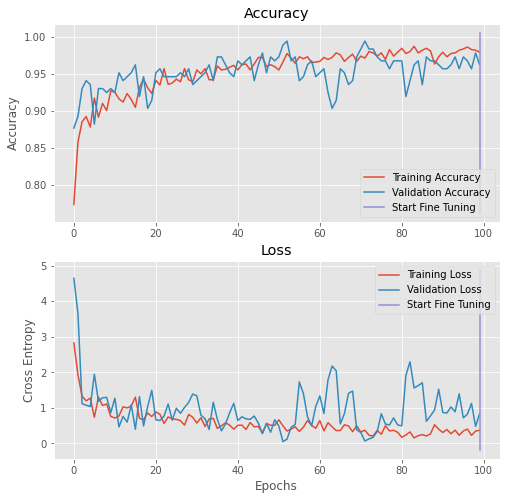

In [23]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot1.pdf")
plt.show()

In [24]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 1.2365 - accuracy: 0.9688

2/5 [===========>..................] - ETA: 2s - loss: 2.5496 - accuracy: 0.9336

3/5 [=================>............] - ETA: 2s - loss: 2.0419 - accuracy: 0.9375

4/5 [=======================>......] - ETA: 1s - loss: 1.8354 - accuracy: 0.9414

5/5 [==============================] - ETA: 0s - loss: 1.8820 - accuracy: 0.9382

5/5 [==============================] - 11s 2s/step - loss: 1.8820 - accuracy: 0.9382


[1.8819584846496582, 0.9381625652313232]

# Fine Tuning

In [25]:
new_model.get_layer('vgg16_features').trainable = False
for layer in new_model.get_layer('vgg16_features').layers:
    for block_name in trainable_blocks:
        if layer.name.startswith(block_name):
            layer.trainable = True
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [26]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 25
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]


In [27]:
cbs += [TensorBoard(tb_path)]

In [28]:
epochs=50

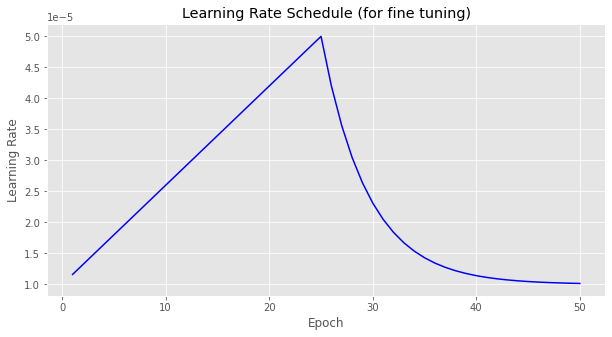

In [29]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]
plt.figure(figsize=(10, 5))
plt.plot(epx, lrs, 'b-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.savefig(path + '/lr_schedule.pdf')
plt.show()

In [30]:
new_model.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

In [31]:
train_ds = dataset(train_path, image_size, crop_size, 64, train=True)

Found 1128 files belonging to 2 classes.


In [32]:
train_history = new_model.fit(train_ds, epochs=init_epochs+epochs, 
                              validation_data=val_ds,
                              initial_epoch=init_epochs,
                              callbacks=cbs,
                              verbose=1)


Epoch 00101: LearningRateScheduler reducing learning rate to 1.0000002156795734e-05.
Epoch 101/150


 1/18 [>.............................] - ETA: 0s - loss: 1.6597 - accuracy: 0.9531

 2/18 [==>...........................] - ETA: 5s - loss: 0.8299 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 11s - loss: 0.5830 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 9s - loss: 0.4372 - accuracy: 0.9844 

 5/18 [=======>......................] - ETA: 10s - loss: 0.4564 - accuracy: 0.9781

 6/18 [=========>....................] - ETA: 14s - loss: 0.4844 - accuracy: 0.9766

 7/18 [==========>...................] - ETA: 11s - loss: 0.4152 - accuracy: 0.9799

 8/18 [============>.................] - ETA: 11s - loss: 0.3633 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 11s - loss: 0.4728 - accuracy: 0.9774

10/18 [===============>..............] - ETA: 10s - loss: 0.4678 - accuracy: 0.9750

11/18 [=================>............] - ETA: 9s - loss: 0.4788 - accuracy: 0.9716 

12/18 [===================>..........] - ETA: 8s - loss: 0.4389 - accuracy: 0.9740

13/18 [====================>.........] - ETA: 6s - loss: 0.4107 - accuracy: 0.9748

14/18 [======================>.......] - ETA: 5s - loss: 0.3813 - accuracy: 0.9766

15/18 [========================>.....] - ETA: 3s - loss: 0.3581 - accuracy: 0.9771

16/18 [=========================>....] - ETA: 2s - loss: 0.3567 - accuracy: 0.9756

17/18 [===========================>..] - ETA: 1s - loss: 0.3441 - accuracy: 0.9761

18/18 [==============================] - ETA: 0s - loss: 0.3319 - accuracy: 0.9770

18/18 [==============================] - 28s 2s/step - loss: 0.3319 - accuracy: 0.9770 - val_loss: 0.5572 - val_accuracy: 0.9786



Epoch 00102: LearningRateScheduler reducing learning rate to 1.0000001725436587e-05.
Epoch 102/150


 1/18 [>.............................] - ETA: 0s - loss: 4.5776e-04 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 4s - loss: 0.0358 - accuracy: 0.9922    

 3/18 [====>.........................] - ETA: 9s - loss: 0.0239 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 16s - loss: 0.1194 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 18s - loss: 0.0955 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 15s - loss: 0.1164 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 12s - loss: 0.1051 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 12s - loss: 0.1002 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 12s - loss: 0.0891 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 10s - loss: 0.1315 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.1195 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 7s - loss: 0.1284 - accuracy: 0.9857

13/18 [====================>.........] - ETA: 6s - loss: 0.1432 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 4s - loss: 0.1415 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 3s - loss: 0.2243 - accuracy: 0.9823

16/18 [=========================>....] - ETA: 2s - loss: 0.2290 - accuracy: 0.9814

17/18 [===========================>..] - ETA: 1s - loss: 0.2156 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.2079 - accuracy: 0.9832

18/18 [==============================] - 24s 1s/step - loss: 0.2079 - accuracy: 0.9832 - val_loss: 0.4546 - val_accuracy: 0.9786



Epoch 00103: LearningRateScheduler reducing learning rate to 1.0000001380349271e-05.
Epoch 103/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1688 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 7s - loss: 0.4484 - accuracy: 0.9688

 3/18 [====>.........................] - ETA: 10s - loss: 0.2989 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 11s - loss: 0.3121 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 16s - loss: 0.3295 - accuracy: 0.9781

 6/18 [=========>....................] - ETA: 13s - loss: 0.3178 - accuracy: 0.9766

 7/18 [==========>...................] - ETA: 15s - loss: 0.2760 - accuracy: 0.9777

 8/18 [============>.................] - ETA: 12s - loss: 0.3530 - accuracy: 0.9766

 9/18 [==============>...............] - ETA: 13s - loss: 0.3993 - accuracy: 0.9722

10/18 [===============>..............] - ETA: 12s - loss: 0.3650 - accuracy: 0.9734

11/18 [=================>............] - ETA: 11s - loss: 0.3832 - accuracy: 0.9730

12/18 [===================>..........] - ETA: 9s - loss: 0.3762 - accuracy: 0.9727 

13/18 [====================>.........] - ETA: 7s - loss: 0.3594 - accuracy: 0.9736

14/18 [======================>.......] - ETA: 5s - loss: 0.4628 - accuracy: 0.9721

15/18 [========================>.....] - ETA: 4s - loss: 0.4370 - accuracy: 0.9729

16/18 [=========================>....] - ETA: 2s - loss: 0.4259 - accuracy: 0.9736

17/18 [===========================>..] - ETA: 1s - loss: 0.4596 - accuracy: 0.9733

18/18 [==============================] - ETA: 0s - loss: 0.4433 - accuracy: 0.9743

18/18 [==============================] - 25s 1s/step - loss: 0.4433 - accuracy: 0.9743 - val_loss: 0.3940 - val_accuracy: 0.9786



Epoch 00104: LearningRateScheduler reducing learning rate to 1.0000001104279416e-05.
Epoch 104/150


 1/18 [>.............................] - ETA: 0s - loss: 0.7297 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 15s - loss: 0.3648 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 21s - loss: 0.3230 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 16s - loss: 0.3313 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 20s - loss: 0.2651 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 17s - loss: 0.2278 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 19s - loss: 0.2392 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 17s - loss: 0.2093 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 15s - loss: 0.2258 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 13s - loss: 0.2103 - accuracy: 0.9859

11/18 [=================>............] - ETA: 11s - loss: 0.2114 - accuracy: 0.9844

12/18 [===================>..........] - ETA: 9s - loss: 0.2383 - accuracy: 0.9831 

13/18 [====================>.........] - ETA: 7s - loss: 0.2206 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.2133 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 4s - loss: 0.2282 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.2613 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.2459 - accuracy: 0.9835

18/18 [==============================] - ETA: 0s - loss: 0.2372 - accuracy: 0.9840

18/18 [==============================] - 26s 1s/step - loss: 0.2372 - accuracy: 0.9840 - val_loss: 0.3473 - val_accuracy: 0.9840



Epoch 00105: LearningRateScheduler reducing learning rate to 1.0000000883423533e-05.
Epoch 105/150


 1/18 [>.............................] - ETA: 0s - loss: 0.3051 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 5s - loss: 0.1908 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 11s - loss: 0.2149 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 16s - loss: 0.2017 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 13s - loss: 0.1809 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 16s - loss: 0.3335 - accuracy: 0.9766

 7/18 [==========>...................] - ETA: 13s - loss: 0.3090 - accuracy: 0.9777

 8/18 [============>.................] - ETA: 13s - loss: 0.2704 - accuracy: 0.9805

 9/18 [==============>...............] - ETA: 12s - loss: 0.2913 - accuracy: 0.9792

10/18 [===============>..............] - ETA: 11s - loss: 0.2738 - accuracy: 0.9797

11/18 [=================>............] - ETA: 10s - loss: 0.2682 - accuracy: 0.9801

12/18 [===================>..........] - ETA: 9s - loss: 0.2594 - accuracy: 0.9792 

13/18 [====================>.........] - ETA: 7s - loss: 0.2618 - accuracy: 0.9796

14/18 [======================>.......] - ETA: 5s - loss: 0.2509 - accuracy: 0.9799

15/18 [========================>.....] - ETA: 4s - loss: 0.3061 - accuracy: 0.9771

16/18 [=========================>....] - ETA: 2s - loss: 0.2870 - accuracy: 0.9785

17/18 [===========================>..] - ETA: 1s - loss: 0.2701 - accuracy: 0.9798

18/18 [==============================] - ETA: 0s - loss: 0.2605 - accuracy: 0.9805

18/18 [==============================] - 25s 1s/step - loss: 0.2605 - accuracy: 0.9805 - val_loss: 0.3202 - val_accuracy: 0.9840



Epoch 00106: LearningRateScheduler reducing learning rate to 1.0000000706738827e-05.
Epoch 106/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2914 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 13s - loss: 0.1459 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 27s - loss: 0.3792 - accuracy: 0.9688

 4/18 [=====>........................] - ETA: 25s - loss: 0.3382 - accuracy: 0.9727

 5/18 [=======>......................] - ETA: 20s - loss: 0.3301 - accuracy: 0.9750

 6/18 [=========>....................] - ETA: 21s - loss: 0.3671 - accuracy: 0.9766

 7/18 [==========>...................] - ETA: 17s - loss: 0.3960 - accuracy: 0.9732

 8/18 [============>.................] - ETA: 14s - loss: 0.3465 - accuracy: 0.9766

 9/18 [==============>...............] - ETA: 13s - loss: 0.3099 - accuracy: 0.9774

10/18 [===============>..............] - ETA: 11s - loss: 0.2949 - accuracy: 0.9766

11/18 [=================>............] - ETA: 9s - loss: 0.2827 - accuracy: 0.9759 

12/18 [===================>..........] - ETA: 8s - loss: 0.2748 - accuracy: 0.9753

13/18 [====================>.........] - ETA: 6s - loss: 0.2821 - accuracy: 0.9748

14/18 [======================>.......] - ETA: 5s - loss: 0.2784 - accuracy: 0.9754

15/18 [========================>.....] - ETA: 3s - loss: 0.2852 - accuracy: 0.9750

16/18 [=========================>....] - ETA: 2s - loss: 0.2674 - accuracy: 0.9766

17/18 [===========================>..] - ETA: 1s - loss: 0.2523 - accuracy: 0.9770

18/18 [==============================] - ETA: 0s - loss: 0.2434 - accuracy: 0.9778

18/18 [==============================] - 25s 1s/step - loss: 0.2434 - accuracy: 0.9778 - val_loss: 0.2867 - val_accuracy: 0.9840



Epoch 00107: LearningRateScheduler reducing learning rate to 1.0000000565391061e-05.
Epoch 107/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0286 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 9s - loss: 0.4548 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 17s - loss: 0.6157 - accuracy: 0.9740

 4/18 [=====>........................] - ETA: 14s - loss: 0.4618 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 14s - loss: 0.5086 - accuracy: 0.9750

 6/18 [=========>....................] - ETA: 16s - loss: 0.6688 - accuracy: 0.9714

 7/18 [==========>...................] - ETA: 15s - loss: 0.5827 - accuracy: 0.9732

 8/18 [============>.................] - ETA: 13s - loss: 0.6299 - accuracy: 0.9727

 9/18 [==============>...............] - ETA: 12s - loss: 0.5600 - accuracy: 0.9757

10/18 [===============>..............] - ETA: 11s - loss: 0.5040 - accuracy: 0.9781

11/18 [=================>............] - ETA: 10s - loss: 0.4756 - accuracy: 0.9787

12/18 [===================>..........] - ETA: 9s - loss: 0.4385 - accuracy: 0.9792 

13/18 [====================>.........] - ETA: 7s - loss: 0.4269 - accuracy: 0.9796

14/18 [======================>.......] - ETA: 5s - loss: 0.4001 - accuracy: 0.9788

15/18 [========================>.....] - ETA: 4s - loss: 0.3746 - accuracy: 0.9792

16/18 [=========================>....] - ETA: 2s - loss: 0.3524 - accuracy: 0.9795

17/18 [===========================>..] - ETA: 1s - loss: 0.3773 - accuracy: 0.9798

18/18 [==============================] - ETA: 0s - loss: 0.3639 - accuracy: 0.9805

18/18 [==============================] - 25s 1s/step - loss: 0.3639 - accuracy: 0.9805 - val_loss: 0.2592 - val_accuracy: 0.9840



Epoch 00108: LearningRateScheduler reducing learning rate to 1.0000000452312849e-05.
Epoch 108/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0204 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 11s - loss: 0.0644 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 23s - loss: 0.1410 - accuracy: 0.9740

 4/18 [=====>........................] - ETA: 18s - loss: 0.1196 - accuracy: 0.9766

 5/18 [=======>......................] - ETA: 22s - loss: 0.1590 - accuracy: 0.9781

 6/18 [=========>....................] - ETA: 21s - loss: 0.2091 - accuracy: 0.9792

 7/18 [==========>...................] - ETA: 17s - loss: 0.1992 - accuracy: 0.9799

 8/18 [============>.................] - ETA: 14s - loss: 0.1743 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 13s - loss: 0.1881 - accuracy: 0.9809

10/18 [===============>..............] - ETA: 11s - loss: 0.1805 - accuracy: 0.9797

11/18 [=================>............] - ETA: 10s - loss: 0.1781 - accuracy: 0.9801

12/18 [===================>..........] - ETA: 8s - loss: 0.1835 - accuracy: 0.9805 

13/18 [====================>.........] - ETA: 6s - loss: 0.2235 - accuracy: 0.9808

14/18 [======================>.......] - ETA: 5s - loss: 0.2076 - accuracy: 0.9821

15/18 [========================>.....] - ETA: 3s - loss: 0.1938 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.1817 - accuracy: 0.9844

17/18 [===========================>..] - ETA: 1s - loss: 0.1745 - accuracy: 0.9844

18/18 [==============================] - ETA: 0s - loss: 0.1683 - accuracy: 0.9849

18/18 [==============================] - 25s 1s/step - loss: 0.1683 - accuracy: 0.9849 - val_loss: 0.2313 - val_accuracy: 0.9840



Epoch 00109: LearningRateScheduler reducing learning rate to 1.000000036185028e-05.
Epoch 109/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2832 - accuracy: 0.9531

 2/18 [==>...........................] - ETA: 11s - loss: 0.2463 - accuracy: 0.9688

 3/18 [====>.........................] - ETA: 23s - loss: 0.1982 - accuracy: 0.9740

 4/18 [=====>........................] - ETA: 22s - loss: 0.2903 - accuracy: 0.9727

 5/18 [=======>......................] - ETA: 17s - loss: 0.2738 - accuracy: 0.9719

 6/18 [=========>....................] - ETA: 17s - loss: 0.2467 - accuracy: 0.9740

 7/18 [==========>...................] - ETA: 15s - loss: 0.2923 - accuracy: 0.9732

 8/18 [============>.................] - ETA: 15s - loss: 0.2920 - accuracy: 0.9746

 9/18 [==============>...............] - ETA: 15s - loss: 0.2595 - accuracy: 0.9774

10/18 [===============>..............] - ETA: 13s - loss: 0.2336 - accuracy: 0.9797

11/18 [=================>............] - ETA: 11s - loss: 0.2281 - accuracy: 0.9801

12/18 [===================>..........] - ETA: 9s - loss: 0.2091 - accuracy: 0.9818 

13/18 [====================>.........] - ETA: 7s - loss: 0.2057 - accuracy: 0.9820

14/18 [======================>.......] - ETA: 5s - loss: 0.1988 - accuracy: 0.9810

15/18 [========================>.....] - ETA: 4s - loss: 0.2242 - accuracy: 0.9781

16/18 [=========================>....] - ETA: 2s - loss: 0.2102 - accuracy: 0.9795

17/18 [===========================>..] - ETA: 1s - loss: 0.2131 - accuracy: 0.9789

18/18 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.9787

18/18 [==============================] - 26s 1s/step - loss: 0.2269 - accuracy: 0.9787 - val_loss: 0.2040 - val_accuracy: 0.9840



Epoch 00110: LearningRateScheduler reducing learning rate to 1.0000000289480224e-05.
Epoch 110/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0645 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 3s - loss: 0.3566 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 12s - loss: 0.3038 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 15s - loss: 0.2375 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 14s - loss: 0.1919 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 13s - loss: 0.4277 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 16s - loss: 0.3714 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 14s - loss: 0.3250 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 12s - loss: 0.2921 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 10s - loss: 0.2629 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.2722 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 7s - loss: 0.2496 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 6s - loss: 0.2477 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.2567 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 3s - loss: 0.2593 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.2978 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.2877 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.2803 - accuracy: 0.9858

18/18 [==============================] - 24s 1s/step - loss: 0.2803 - accuracy: 0.9858 - val_loss: 0.1951 - val_accuracy: 0.9840



Epoch 00111: LearningRateScheduler reducing learning rate to 1.0000000231584179e-05.
Epoch 111/150


 1/18 [>.............................] - ETA: 0s - loss: 0.5732 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 10s - loss: 0.3997 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 21s - loss: 0.4656 - accuracy: 0.9740

 4/18 [=====>........................] - ETA: 20s - loss: 0.3492 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 18s - loss: 0.2793 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 15s - loss: 0.2328 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 15s - loss: 0.2466 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 13s - loss: 0.2159 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 13s - loss: 0.1919 - accuracy: 0.9896

10/18 [===============>..............] - ETA: 11s - loss: 0.2046 - accuracy: 0.9875

11/18 [=================>............] - ETA: 9s - loss: 0.2119 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 8s - loss: 0.1992 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 6s - loss: 0.1846 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 5s - loss: 0.1943 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 3s - loss: 0.2099 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.2375 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.2419 - accuracy: 0.9853

18/18 [==============================] - ETA: 0s - loss: 0.2334 - accuracy: 0.9858

18/18 [==============================] - 25s 1s/step - loss: 0.2334 - accuracy: 0.9858 - val_loss: 0.1882 - val_accuracy: 0.9840



Epoch 00112: LearningRateScheduler reducing learning rate to 1.0000000185267343e-05.
Epoch 112/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1691 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 7s - loss: 0.0846 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 7s - loss: 0.0564 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 14s - loss: 0.1032 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 11s - loss: 0.1229 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 14s - loss: 0.2121 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 12s - loss: 0.2939 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 13s - loss: 0.2572 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 11s - loss: 0.2298 - accuracy: 0.9896

10/18 [===============>..............] - ETA: 9s - loss: 0.2419 - accuracy: 0.9875 

11/18 [=================>............] - ETA: 8s - loss: 0.2199 - accuracy: 0.9886

12/18 [===================>..........] - ETA: 7s - loss: 0.2905 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 6s - loss: 0.2918 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.2733 - accuracy: 0.9855

15/18 [========================>.....] - ETA: 3s - loss: 0.2550 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.2404 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.3111 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.3268 - accuracy: 0.9814

18/18 [==============================] - 23s 1s/step - loss: 0.3268 - accuracy: 0.9814 - val_loss: 0.1890 - val_accuracy: 0.9840



Epoch 00113: LearningRateScheduler reducing learning rate to 1.0000000148213875e-05.
Epoch 113/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1830 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 3s - loss: 0.1933 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 24s - loss: 0.5362 - accuracy: 0.9740

 4/18 [=====>........................] - ETA: 23s - loss: 0.4497 - accuracy: 0.9727

 5/18 [=======>......................] - ETA: 20s - loss: 0.3964 - accuracy: 0.9750

 6/18 [=========>....................] - ETA: 17s - loss: 0.4126 - accuracy: 0.9766

 7/18 [==========>...................] - ETA: 14s - loss: 0.3536 - accuracy: 0.9799

 8/18 [============>.................] - ETA: 12s - loss: 0.3095 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 12s - loss: 0.2958 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 11s - loss: 0.2901 - accuracy: 0.9828

11/18 [=================>............] - ETA: 9s - loss: 0.2650 - accuracy: 0.9830 

12/18 [===================>..........] - ETA: 7s - loss: 0.2440 - accuracy: 0.9831

13/18 [====================>.........] - ETA: 6s - loss: 0.2286 - accuracy: 0.9832

14/18 [======================>.......] - ETA: 5s - loss: 0.2359 - accuracy: 0.9810

15/18 [========================>.....] - ETA: 3s - loss: 0.2201 - accuracy: 0.9823

16/18 [=========================>....] - ETA: 2s - loss: 0.2082 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.1980 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.2378 - accuracy: 0.9814

18/18 [==============================] - 24s 1s/step - loss: 0.2378 - accuracy: 0.9814 - val_loss: 0.1814 - val_accuracy: 0.9840



Epoch 00114: LearningRateScheduler reducing learning rate to 1.00000001185711e-05.
Epoch 114/150


 1/18 [>.............................] - ETA: 0s - loss: 0.7154 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 14s - loss: 0.5564 - accuracy: 0.9688

 3/18 [====>.........................] - ETA: 23s - loss: 0.4580 - accuracy: 0.9740

 4/18 [=====>........................] - ETA: 21s - loss: 0.3435 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 19s - loss: 0.2885 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 19s - loss: 0.2435 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 16s - loss: 0.2087 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 14s - loss: 0.1826 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.1626 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 11s - loss: 0.1524 - accuracy: 0.9875

11/18 [=================>............] - ETA: 9s - loss: 0.1434 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 8s - loss: 0.1407 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 7s - loss: 0.1345 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.2070 - accuracy: 0.9855

15/18 [========================>.....] - ETA: 4s - loss: 0.2298 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.2327 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.2190 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.9849

18/18 [==============================] - 26s 1s/step - loss: 0.2325 - accuracy: 0.9849 - val_loss: 0.1681 - val_accuracy: 0.9840



Epoch 00115: LearningRateScheduler reducing learning rate to 1.0000000094856881e-05.
Epoch 115/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1380 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 9s - loss: 0.3173 - accuracy: 0.9688

 3/18 [====>.........................] - ETA: 13s - loss: 0.5843 - accuracy: 0.9531

 4/18 [=====>........................] - ETA: 13s - loss: 0.4451 - accuracy: 0.9609

 5/18 [=======>......................] - ETA: 15s - loss: 0.5407 - accuracy: 0.9625

 6/18 [=========>....................] - ETA: 13s - loss: 0.5822 - accuracy: 0.9661

 7/18 [==========>...................] - ETA: 14s - loss: 0.4992 - accuracy: 0.9710

 8/18 [============>.................] - ETA: 13s - loss: 0.4856 - accuracy: 0.9727

 9/18 [==============>...............] - ETA: 11s - loss: 0.4316 - accuracy: 0.9757

10/18 [===============>..............] - ETA: 10s - loss: 0.3885 - accuracy: 0.9781

11/18 [=================>............] - ETA: 8s - loss: 0.3540 - accuracy: 0.9801 

12/18 [===================>..........] - ETA: 7s - loss: 0.3481 - accuracy: 0.9805

13/18 [====================>.........] - ETA: 6s - loss: 0.3641 - accuracy: 0.9808

14/18 [======================>.......] - ETA: 4s - loss: 0.3381 - accuracy: 0.9821

15/18 [========================>.....] - ETA: 3s - loss: 0.3510 - accuracy: 0.9812

16/18 [=========================>....] - ETA: 2s - loss: 0.3291 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.3403 - accuracy: 0.9816

18/18 [==============================] - ETA: 0s - loss: 0.3596 - accuracy: 0.9814

18/18 [==============================] - 23s 1s/step - loss: 0.3596 - accuracy: 0.9814 - val_loss: 0.1512 - val_accuracy: 0.9840



Epoch 00116: LearningRateScheduler reducing learning rate to 1.0000000075885505e-05.
Epoch 116/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0819 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 9s - loss: 0.2106 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 12s - loss: 0.3108 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 15s - loss: 0.2427 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 14s - loss: 0.1942 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 13s - loss: 0.1618 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 13s - loss: 0.1437 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 12s - loss: 0.1258 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 12s - loss: 0.1417 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 10s - loss: 0.1275 - accuracy: 0.9891

11/18 [=================>............] - ETA: 9s - loss: 0.1159 - accuracy: 0.9901 

12/18 [===================>..........] - ETA: 7s - loss: 0.1385 - accuracy: 0.9896

13/18 [====================>.........] - ETA: 6s - loss: 0.1278 - accuracy: 0.9904

14/18 [======================>.......] - ETA: 4s - loss: 0.1333 - accuracy: 0.9900

15/18 [========================>.....] - ETA: 3s - loss: 0.1245 - accuracy: 0.9906

16/18 [=========================>....] - ETA: 2s - loss: 0.1250 - accuracy: 0.9902

17/18 [===========================>..] - ETA: 1s - loss: 0.1422 - accuracy: 0.9899

18/18 [==============================] - ETA: 0s - loss: 0.1372 - accuracy: 0.9902

18/18 [==============================] - 24s 1s/step - loss: 0.1372 - accuracy: 0.9902 - val_loss: 0.1414 - val_accuracy: 0.9840



Epoch 00117: LearningRateScheduler reducing learning rate to 1.0000000060708404e-05.
Epoch 117/150


 1/18 [>.............................] - ETA: 0s - loss: 0.3895 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 19s - loss: 0.2464 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 23s - loss: 0.1642 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 19s - loss: 0.2194 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 17s - loss: 0.1982 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 15s - loss: 0.1653 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 15s - loss: 0.1708 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 13s - loss: 0.2950 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 13s - loss: 0.3155 - accuracy: 0.9809

10/18 [===============>..............] - ETA: 11s - loss: 0.2928 - accuracy: 0.9812

11/18 [=================>............] - ETA: 9s - loss: 0.2662 - accuracy: 0.9830 

12/18 [===================>..........] - ETA: 8s - loss: 0.3256 - accuracy: 0.9779

13/18 [====================>.........] - ETA: 7s - loss: 0.3005 - accuracy: 0.9796

14/18 [======================>.......] - ETA: 5s - loss: 0.2791 - accuracy: 0.9810

15/18 [========================>.....] - ETA: 4s - loss: 0.2931 - accuracy: 0.9802

16/18 [=========================>....] - ETA: 2s - loss: 0.2756 - accuracy: 0.9805

17/18 [===========================>..] - ETA: 1s - loss: 0.2815 - accuracy: 0.9807

18/18 [==============================] - ETA: 0s - loss: 0.2715 - accuracy: 0.9814

18/18 [==============================] - 25s 1s/step - loss: 0.2715 - accuracy: 0.9814 - val_loss: 0.1375 - val_accuracy: 0.9840



Epoch 00118: LearningRateScheduler reducing learning rate to 1.0000000048566724e-05.
Epoch 118/150


 1/18 [>.............................] - ETA: 0s - loss: 2.0513e-05 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 19s - loss: 0.0831 - accuracy: 0.9922   

 3/18 [====>.........................] - ETA: 17s - loss: 0.1865 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 16s - loss: 0.1398 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 20s - loss: 0.1942 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 16s - loss: 0.1810 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 17s - loss: 0.1552 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 16s - loss: 0.1358 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 15s - loss: 0.1397 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 13s - loss: 0.2627 - accuracy: 0.9906

11/18 [=================>............] - ETA: 11s - loss: 0.2666 - accuracy: 0.9901

12/18 [===================>..........] - ETA: 9s - loss: 0.2443 - accuracy: 0.9909 

13/18 [====================>.........] - ETA: 7s - loss: 0.2397 - accuracy: 0.9904

14/18 [======================>.......] - ETA: 6s - loss: 0.2226 - accuracy: 0.9911

15/18 [========================>.....] - ETA: 4s - loss: 0.2169 - accuracy: 0.9906

16/18 [=========================>....] - ETA: 2s - loss: 0.2687 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.2694 - accuracy: 0.9835

18/18 [==============================] - ETA: 0s - loss: 0.2948 - accuracy: 0.9832

18/18 [==============================] - 26s 1s/step - loss: 0.2948 - accuracy: 0.9832 - val_loss: 0.1279 - val_accuracy: 0.9840



Epoch 00119: LearningRateScheduler reducing learning rate to 1.0000000038853378e-05.
Epoch 119/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1287 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 11s - loss: 0.4102 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 20s - loss: 0.2734 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 19s - loss: 0.2735 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 20s - loss: 0.2188 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 16s - loss: 0.1927 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 15s - loss: 0.1652 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 18s - loss: 0.1445 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 16s - loss: 0.1977 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 14s - loss: 0.2243 - accuracy: 0.9859

11/18 [=================>............] - ETA: 12s - loss: 0.2795 - accuracy: 0.9858

12/18 [===================>..........] - ETA: 10s - loss: 0.2684 - accuracy: 0.9857

13/18 [====================>.........] - ETA: 8s - loss: 0.2700 - accuracy: 0.9856 

14/18 [======================>.......] - ETA: 6s - loss: 0.2818 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 4s - loss: 0.2630 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.2803 - accuracy: 0.9844

17/18 [===========================>..] - ETA: 1s - loss: 0.2639 - accuracy: 0.9853

18/18 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.9849

18/18 [==============================] - 26s 1s/step - loss: 0.2623 - accuracy: 0.9849 - val_loss: 0.1160 - val_accuracy: 0.9840



Epoch 00120: LearningRateScheduler reducing learning rate to 1.0000000031082703e-05.
Epoch 120/150


 1/18 [>.............................] - ETA: 0s - loss: 0.5780 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 10s - loss: 0.7862 - accuracy: 0.9688

 3/18 [====>.........................] - ETA: 24s - loss: 0.5242 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 22s - loss: 0.3931 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 17s - loss: 0.4261 - accuracy: 0.9781

 6/18 [=========>....................] - ETA: 16s - loss: 0.4296 - accuracy: 0.9792

 7/18 [==========>...................] - ETA: 15s - loss: 0.5475 - accuracy: 0.9710

 8/18 [============>.................] - ETA: 14s - loss: 0.4790 - accuracy: 0.9746

 9/18 [==============>...............] - ETA: 13s - loss: 0.4377 - accuracy: 0.9757

10/18 [===============>..............] - ETA: 11s - loss: 0.4288 - accuracy: 0.9766

11/18 [=================>............] - ETA: 9s - loss: 0.5117 - accuracy: 0.9730 

12/18 [===================>..........] - ETA: 8s - loss: 0.4691 - accuracy: 0.9753

13/18 [====================>.........] - ETA: 6s - loss: 0.4330 - accuracy: 0.9772

14/18 [======================>.......] - ETA: 5s - loss: 0.4241 - accuracy: 0.9766

15/18 [========================>.....] - ETA: 3s - loss: 0.3959 - accuracy: 0.9781

16/18 [=========================>....] - ETA: 2s - loss: 0.3713 - accuracy: 0.9795

17/18 [===========================>..] - ETA: 1s - loss: 0.3495 - accuracy: 0.9807

18/18 [==============================] - ETA: 0s - loss: 0.3976 - accuracy: 0.9796

18/18 [==============================] - 25s 1s/step - loss: 0.3976 - accuracy: 0.9796 - val_loss: 0.1292 - val_accuracy: 0.9840



Epoch 00121: LearningRateScheduler reducing learning rate to 1.0000000024866162e-05.
Epoch 121/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1633 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 12s - loss: 0.0835 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 27s - loss: 0.0677 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 21s - loss: 0.2203 - accuracy: 0.9727

 5/18 [=======>......................] - ETA: 20s - loss: 0.2298 - accuracy: 0.9750

 6/18 [=========>....................] - ETA: 16s - loss: 0.1915 - accuracy: 0.9792

 7/18 [==========>...................] - ETA: 15s - loss: 0.1650 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 14s - loss: 0.1564 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 13s - loss: 0.1391 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.1252 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.1152 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 8s - loss: 0.1342 - accuracy: 0.9844

13/18 [====================>.........] - ETA: 6s - loss: 0.1244 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.1159 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 3s - loss: 0.1081 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.1016 - accuracy: 0.9883

17/18 [===========================>..] - ETA: 1s - loss: 0.1169 - accuracy: 0.9881

18/18 [==============================] - ETA: 0s - loss: 0.1128 - accuracy: 0.9885

18/18 [==============================] - 25s 1s/step - loss: 0.1128 - accuracy: 0.9885 - val_loss: 0.1332 - val_accuracy: 0.9840



Epoch 00122: LearningRateScheduler reducing learning rate to 1.000000001989293e-05.
Epoch 122/150


 1/18 [>.............................] - ETA: 0s - loss: 2.0489e-08 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 3s - loss: 0.0605 - accuracy: 0.9922    

 3/18 [====>.........................] - ETA: 20s - loss: 0.1394 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 15s - loss: 0.1191 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 18s - loss: 0.2861 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 15s - loss: 0.3354 - accuracy: 0.9792

 7/18 [==========>...................] - ETA: 14s - loss: 0.4463 - accuracy: 0.9710

 8/18 [============>.................] - ETA: 14s - loss: 0.4073 - accuracy: 0.9727

 9/18 [==============>...............] - ETA: 12s - loss: 0.4132 - accuracy: 0.9705

10/18 [===============>..............] - ETA: 11s - loss: 0.3720 - accuracy: 0.9734

11/18 [=================>............] - ETA: 9s - loss: 0.3604 - accuracy: 0.9730 

12/18 [===================>..........] - ETA: 8s - loss: 0.3453 - accuracy: 0.9740

13/18 [====================>.........] - ETA: 6s - loss: 0.3274 - accuracy: 0.9748

14/18 [======================>.......] - ETA: 5s - loss: 0.3045 - accuracy: 0.9766

15/18 [========================>.....] - ETA: 3s - loss: 0.2845 - accuracy: 0.9781

16/18 [=========================>....] - ETA: 2s - loss: 0.2667 - accuracy: 0.9795

17/18 [===========================>..] - ETA: 1s - loss: 0.2560 - accuracy: 0.9798

18/18 [==============================] - ETA: 0s - loss: 0.2720 - accuracy: 0.9796

18/18 [==============================] - 25s 1s/step - loss: 0.2720 - accuracy: 0.9796 - val_loss: 0.1352 - val_accuracy: 0.9840



Epoch 00123: LearningRateScheduler reducing learning rate to 1.0000000015914344e-05.
Epoch 123/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1426 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 7s - loss: 0.1321 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 7s - loss: 0.2363 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 10s - loss: 0.1773 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 15s - loss: 0.1594 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 12s - loss: 0.1328 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 16s - loss: 0.1138 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 14s - loss: 0.1002 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 12s - loss: 0.0890 - accuracy: 0.9931

10/18 [===============>..............] - ETA: 11s - loss: 0.0801 - accuracy: 0.9937

11/18 [=================>............] - ETA: 10s - loss: 0.0749 - accuracy: 0.9929

12/18 [===================>..........] - ETA: 9s - loss: 0.0687 - accuracy: 0.9935 

13/18 [====================>.........] - ETA: 7s - loss: 0.0634 - accuracy: 0.9940

14/18 [======================>.......] - ETA: 5s - loss: 0.0589 - accuracy: 0.9944

15/18 [========================>.....] - ETA: 3s - loss: 0.0630 - accuracy: 0.9937

16/18 [=========================>....] - ETA: 2s - loss: 0.0930 - accuracy: 0.9912

17/18 [===========================>..] - ETA: 1s - loss: 0.0993 - accuracy: 0.9908

18/18 [==============================] - ETA: 0s - loss: 0.0958 - accuracy: 0.9911

18/18 [==============================] - 24s 1s/step - loss: 0.0958 - accuracy: 0.9911 - val_loss: 0.1364 - val_accuracy: 0.9840



Epoch 00124: LearningRateScheduler reducing learning rate to 1.0000000012731475e-05.
Epoch 124/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2837 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 10s - loss: 0.1418 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 21s - loss: 0.0946 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 16s - loss: 0.1711 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 19s - loss: 0.1464 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 17s - loss: 0.1376 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 18s - loss: 0.1180 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 15s - loss: 0.1337 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 13s - loss: 0.1190 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 11s - loss: 0.1071 - accuracy: 0.9922

11/18 [=================>............] - ETA: 9s - loss: 0.0974 - accuracy: 0.9929 

12/18 [===================>..........] - ETA: 8s - loss: 0.0894 - accuracy: 0.9935

13/18 [====================>.........] - ETA: 7s - loss: 0.1092 - accuracy: 0.9928

14/18 [======================>.......] - ETA: 5s - loss: 0.1077 - accuracy: 0.9922

15/18 [========================>.....] - ETA: 4s - loss: 0.1005 - accuracy: 0.9927

16/18 [=========================>....] - ETA: 2s - loss: 0.1257 - accuracy: 0.9912

17/18 [===========================>..] - ETA: 1s - loss: 0.1664 - accuracy: 0.9899

18/18 [==============================] - ETA: 0s - loss: 0.2016 - accuracy: 0.9867

18/18 [==============================] - 26s 1s/step - loss: 0.2016 - accuracy: 0.9867 - val_loss: 0.1343 - val_accuracy: 0.9840



Epoch 00125: LearningRateScheduler reducing learning rate to 1.000000001018518e-05.
Epoch 125/150


 1/18 [>.............................] - ETA: 0s - loss: 2.3524e-05 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 19s - loss: 1.1762e-05 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 17s - loss: 0.0205 - accuracy: 0.9948    

 4/18 [=====>........................] - ETA: 16s - loss: 0.0154 - accuracy: 0.9961

 5/18 [=======>......................] - ETA: 20s - loss: 0.0123 - accuracy: 0.9969

 6/18 [=========>....................] - ETA: 16s - loss: 0.2088 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 18s - loss: 0.1865 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 15s - loss: 0.1728 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 13s - loss: 0.1539 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 11s - loss: 0.1559 - accuracy: 0.9875

11/18 [=================>............] - ETA: 9s - loss: 0.1563 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 8s - loss: 0.1433 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 6s - loss: 0.1497 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.1390 - accuracy: 0.9855

15/18 [========================>.....] - ETA: 3s - loss: 0.1299 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.1218 - accuracy: 0.9873

17/18 [===========================>..] - ETA: 1s - loss: 0.1146 - accuracy: 0.9881

18/18 [==============================] - ETA: 0s - loss: 0.1106 - accuracy: 0.9885

18/18 [==============================] - 25s 1s/step - loss: 0.1106 - accuracy: 0.9885 - val_loss: 0.1429 - val_accuracy: 0.9840



Epoch 00126: LearningRateScheduler reducing learning rate to 1.0000000008148144e-05.
Epoch 126/150


 1/18 [>.............................] - ETA: 0s - loss: 0.6714 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 10s - loss: 0.3357 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 17s - loss: 0.2536 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 19s - loss: 0.2758 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 20s - loss: 0.2761 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 16s - loss: 0.2402 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 17s - loss: 0.2250 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 15s - loss: 0.2067 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 13s - loss: 0.2960 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 11s - loss: 0.2883 - accuracy: 0.9828

11/18 [=================>............] - ETA: 9s - loss: 0.2622 - accuracy: 0.9844 

12/18 [===================>..........] - ETA: 8s - loss: 0.3587 - accuracy: 0.9818

13/18 [====================>.........] - ETA: 6s - loss: 0.3330 - accuracy: 0.9820

14/18 [======================>.......] - ETA: 5s - loss: 0.3092 - accuracy: 0.9833

15/18 [========================>.....] - ETA: 3s - loss: 0.3103 - accuracy: 0.9812

16/18 [=========================>....] - ETA: 2s - loss: 0.2909 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.2738 - accuracy: 0.9835

18/18 [==============================] - ETA: 0s - loss: 0.2641 - accuracy: 0.9840

18/18 [==============================] - 25s 1s/step - loss: 0.2641 - accuracy: 0.9840 - val_loss: 0.1519 - val_accuracy: 0.9786



Epoch 00127: LearningRateScheduler reducing learning rate to 1.0000000006518516e-05.
Epoch 127/150


 1/18 [>.............................] - ETA: 0s - loss: 7.5642e-06 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 19s - loss: 3.7858e-06 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 21s - loss: 4.1477e-04 - accuracy: 1.0000

 4/18 [=====>........................] - ETA: 16s - loss: 3.1750e-04 - accuracy: 1.0000

 5/18 [=======>......................] - ETA: 17s - loss: 7.1123e-04 - accuracy: 1.0000

 6/18 [=========>....................] - ETA: 17s - loss: 5.9291e-04 - accuracy: 1.0000

 7/18 [==========>...................] - ETA: 16s - loss: 5.2711e-04 - accuracy: 1.0000

 8/18 [============>.................] - ETA: 13s - loss: 4.6122e-04 - accuracy: 1.0000

 9/18 [==============>...............] - ETA: 13s - loss: 0.0265 - accuracy: 0.9965    

10/18 [===============>..............] - ETA: 11s - loss: 0.0739 - accuracy: 0.9922

11/18 [=================>............] - ETA: 9s - loss: 0.0674 - accuracy: 0.9929 

12/18 [===================>..........] - ETA: 8s - loss: 0.0619 - accuracy: 0.9935

13/18 [====================>.........] - ETA: 6s - loss: 0.0571 - accuracy: 0.9940

14/18 [======================>.......] - ETA: 5s - loss: 0.0745 - accuracy: 0.9933

15/18 [========================>.....] - ETA: 4s - loss: 0.0695 - accuracy: 0.9937

16/18 [=========================>....] - ETA: 2s - loss: 0.1034 - accuracy: 0.9922

17/18 [===========================>..] - ETA: 1s - loss: 0.1035 - accuracy: 0.9917

18/18 [==============================] - ETA: 0s - loss: 0.0998 - accuracy: 0.9920

18/18 [==============================] - 25s 1s/step - loss: 0.0998 - accuracy: 0.9920 - val_loss: 0.1562 - val_accuracy: 0.9786



Epoch 00128: LearningRateScheduler reducing learning rate to 1.0000000005214813e-05.
Epoch 128/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1837 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 11s - loss: 0.2165 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 18s - loss: 0.3597 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 17s - loss: 0.2899 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 20s - loss: 0.2319 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 16s - loss: 0.1933 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 15s - loss: 0.2269 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 13s - loss: 0.1986 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.1765 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 11s - loss: 0.1876 - accuracy: 0.9859

11/18 [=================>............] - ETA: 10s - loss: 0.1705 - accuracy: 0.9872

12/18 [===================>..........] - ETA: 8s - loss: 0.1895 - accuracy: 0.9844 

13/18 [====================>.........] - ETA: 6s - loss: 0.1749 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.1625 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 3s - loss: 0.2142 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.2044 - accuracy: 0.9834

17/18 [===========================>..] - ETA: 1s - loss: 0.2005 - accuracy: 0.9835

18/18 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.9840

18/18 [==============================] - 25s 1s/step - loss: 0.1939 - accuracy: 0.9840 - val_loss: 0.1646 - val_accuracy: 0.9786



Epoch 00129: LearningRateScheduler reducing learning rate to 1.000000000417185e-05.
Epoch 129/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1120 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 3s - loss: 0.1150 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 15s - loss: 0.0766 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 17s - loss: 0.0575 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 16s - loss: 0.0497 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 15s - loss: 0.0669 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 14s - loss: 0.0700 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 14s - loss: 0.0804 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 13s - loss: 0.0730 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.0657 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.0799 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 7s - loss: 0.1060 - accuracy: 0.9844

13/18 [====================>.........] - ETA: 6s - loss: 0.1647 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.1538 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 3s - loss: 0.1591 - accuracy: 0.9844

16/18 [=========================>....] - ETA: 2s - loss: 0.1768 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.1768 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.1706 - accuracy: 0.9832

18/18 [==============================] - 24s 1s/step - loss: 0.1706 - accuracy: 0.9832 - val_loss: 0.1509 - val_accuracy: 0.9786



Epoch 00130: LearningRateScheduler reducing learning rate to 1.000000000333748e-05.
Epoch 130/150


 1/18 [>.............................] - ETA: 0s - loss: 0.4756 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 18s - loss: 0.2379 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 21s - loss: 0.3940 - accuracy: 0.9740

 4/18 [=====>........................] - ETA: 16s - loss: 0.2955 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 22s - loss: 0.2364 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 20s - loss: 0.2582 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 17s - loss: 0.2679 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 15s - loss: 0.2344 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.2085 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 11s - loss: 0.1876 - accuracy: 0.9891

11/18 [=================>............] - ETA: 9s - loss: 0.1952 - accuracy: 0.9886 

12/18 [===================>..........] - ETA: 8s - loss: 0.1789 - accuracy: 0.9896

13/18 [====================>.........] - ETA: 6s - loss: 0.2232 - accuracy: 0.9892

14/18 [======================>.......] - ETA: 5s - loss: 0.2699 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 4s - loss: 0.2778 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.2604 - accuracy: 0.9883

17/18 [===========================>..] - ETA: 1s - loss: 0.2451 - accuracy: 0.9890

18/18 [==============================] - ETA: 0s - loss: 0.2364 - accuracy: 0.9894

18/18 [==============================] - 25s 1s/step - loss: 0.2364 - accuracy: 0.9894 - val_loss: 0.1646 - val_accuracy: 0.9786



Epoch 00131: LearningRateScheduler reducing learning rate to 1.0000000002669984e-05.
Epoch 131/150


 1/18 [>.............................] - ETA: 0s - loss: 0.6974 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 33s - loss: 0.3501 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 30s - loss: 0.3561 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 26s - loss: 0.2673 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 20s - loss: 0.2218 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 18s - loss: 0.2089 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 15s - loss: 0.1863 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 15s - loss: 0.1687 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.2241 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 11s - loss: 0.2087 - accuracy: 0.9828

11/18 [=================>............] - ETA: 10s - loss: 0.1897 - accuracy: 0.9844

12/18 [===================>..........] - ETA: 8s - loss: 0.2181 - accuracy: 0.9844 

13/18 [====================>.........] - ETA: 6s - loss: 0.2013 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.2119 - accuracy: 0.9855

15/18 [========================>.....] - ETA: 4s - loss: 0.1978 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.2404 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.2505 - accuracy: 0.9853

18/18 [==============================] - ETA: 0s - loss: 0.2419 - accuracy: 0.9858

18/18 [==============================] - 25s 1s/step - loss: 0.2419 - accuracy: 0.9858 - val_loss: 0.1717 - val_accuracy: 0.9786



Epoch 00132: LearningRateScheduler reducing learning rate to 1.0000000002135988e-05.
Epoch 132/150


 1/18 [>.............................] - ETA: 0s - loss: 0.4381 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 20s - loss: 0.6105 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 21s - loss: 0.4070 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 25s - loss: 0.3879 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 20s - loss: 0.3112 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 17s - loss: 0.2594 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 15s - loss: 0.3193 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 15s - loss: 0.3247 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.2886 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 11s - loss: 0.2598 - accuracy: 0.9891

11/18 [=================>............] - ETA: 10s - loss: 0.2361 - accuracy: 0.9901

12/18 [===================>..........] - ETA: 8s - loss: 0.2165 - accuracy: 0.9909 

13/18 [====================>.........] - ETA: 6s - loss: 0.2070 - accuracy: 0.9904

14/18 [======================>.......] - ETA: 5s - loss: 0.1922 - accuracy: 0.9911

15/18 [========================>.....] - ETA: 3s - loss: 0.2092 - accuracy: 0.9896

16/18 [=========================>....] - ETA: 2s - loss: 0.2191 - accuracy: 0.9893

17/18 [===========================>..] - ETA: 1s - loss: 0.2065 - accuracy: 0.9899

18/18 [==============================] - ETA: 0s - loss: 0.2459 - accuracy: 0.9894

18/18 [==============================] - 25s 1s/step - loss: 0.2459 - accuracy: 0.9894 - val_loss: 0.1583 - val_accuracy: 0.9786



Epoch 00133: LearningRateScheduler reducing learning rate to 1.000000000170879e-05.
Epoch 133/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2860 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 10s - loss: 0.3767 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 9s - loss: 0.5901 - accuracy: 0.9688 

 4/18 [=====>........................] - ETA: 10s - loss: 0.4426 - accuracy: 0.9766

 5/18 [=======>......................] - ETA: 12s - loss: 0.3638 - accuracy: 0.9781

 6/18 [=========>....................] - ETA: 12s - loss: 0.3660 - accuracy: 0.9792

 7/18 [==========>...................] - ETA: 14s - loss: 0.3287 - accuracy: 0.9799

 8/18 [============>.................] - ETA: 13s - loss: 0.3243 - accuracy: 0.9766

 9/18 [==============>...............] - ETA: 11s - loss: 0.5093 - accuracy: 0.9740

10/18 [===============>..............] - ETA: 10s - loss: 0.4590 - accuracy: 0.9766

11/18 [=================>............] - ETA: 8s - loss: 0.4173 - accuracy: 0.9787 

12/18 [===================>..........] - ETA: 7s - loss: 0.4484 - accuracy: 0.9779

13/18 [====================>.........] - ETA: 6s - loss: 0.4139 - accuracy: 0.9796

14/18 [======================>.......] - ETA: 4s - loss: 0.3844 - accuracy: 0.9810

15/18 [========================>.....] - ETA: 3s - loss: 0.3678 - accuracy: 0.9812

16/18 [=========================>....] - ETA: 2s - loss: 0.3448 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.3311 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.3193 - accuracy: 0.9832

18/18 [==============================] - 23s 1s/step - loss: 0.3193 - accuracy: 0.9832 - val_loss: 0.1584 - val_accuracy: 0.9786



Epoch 00134: LearningRateScheduler reducing learning rate to 1.0000000001367032e-05.
Epoch 134/150


 1/18 [>.............................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 19s - loss: 0.0483 - accuracy: 0.9922   

 3/18 [====>.........................] - ETA: 29s - loss: 0.0681 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 22s - loss: 0.0871 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 17s - loss: 0.0786 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 20s - loss: 0.0961 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 17s - loss: 0.0824 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 14s - loss: 0.0721 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 13s - loss: 0.0882 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 11s - loss: 0.1318 - accuracy: 0.9875

11/18 [=================>............] - ETA: 10s - loss: 0.1198 - accuracy: 0.9886

12/18 [===================>..........] - ETA: 9s - loss: 0.1261 - accuracy: 0.9883 

13/18 [====================>.........] - ETA: 7s - loss: 0.1549 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 5s - loss: 0.1440 - accuracy: 0.9888

15/18 [========================>.....] - ETA: 4s - loss: 0.1603 - accuracy: 0.9885

16/18 [=========================>....] - ETA: 2s - loss: 0.1502 - accuracy: 0.9893

17/18 [===========================>..] - ETA: 1s - loss: 0.1559 - accuracy: 0.9890

18/18 [==============================] - ETA: 0s - loss: 0.1504 - accuracy: 0.9894

18/18 [==============================] - 25s 1s/step - loss: 0.1504 - accuracy: 0.9894 - val_loss: 0.1624 - val_accuracy: 0.9786



Epoch 00135: LearningRateScheduler reducing learning rate to 1.0000000001093625e-05.
Epoch 135/150


 1/18 [>.............................] - ETA: 0s - loss: 8.5314e-05 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 11s - loss: 0.2038 - accuracy: 0.9844   

 3/18 [====>.........................] - ETA: 17s - loss: 0.1358 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 16s - loss: 0.1019 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 17s - loss: 0.1622 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 15s - loss: 0.1712 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 17s - loss: 0.1741 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 15s - loss: 0.1523 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 14s - loss: 0.1507 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 14s - loss: 0.1357 - accuracy: 0.9891

11/18 [=================>............] - ETA: 12s - loss: 0.1402 - accuracy: 0.9886

12/18 [===================>..........] - ETA: 10s - loss: 0.1286 - accuracy: 0.9896

13/18 [====================>.........] - ETA: 8s - loss: 0.1187 - accuracy: 0.9904 

14/18 [======================>.......] - ETA: 6s - loss: 0.1102 - accuracy: 0.9911

15/18 [========================>.....] - ETA: 4s - loss: 0.1028 - accuracy: 0.9917

16/18 [=========================>....] - ETA: 2s - loss: 0.0964 - accuracy: 0.9922

17/18 [===========================>..] - ETA: 1s - loss: 0.1314 - accuracy: 0.9908

18/18 [==============================] - ETA: 0s - loss: 0.1638 - accuracy: 0.9902

18/18 [==============================] - 27s 1s/step - loss: 0.1638 - accuracy: 0.9902 - val_loss: 0.1585 - val_accuracy: 0.9786



Epoch 00136: LearningRateScheduler reducing learning rate to 1.0000000000874901e-05.
Epoch 136/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0177 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 4s - loss: 0.3628 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 12s - loss: 0.2430 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 17s - loss: 0.2625 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 17s - loss: 0.3100 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 16s - loss: 0.2583 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 13s - loss: 0.2222 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 12s - loss: 0.2184 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 12s - loss: 0.1941 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 10s - loss: 0.1762 - accuracy: 0.9875

11/18 [=================>............] - ETA: 9s - loss: 0.1602 - accuracy: 0.9886 

12/18 [===================>..........] - ETA: 7s - loss: 0.1869 - accuracy: 0.9883

13/18 [====================>.........] - ETA: 6s - loss: 0.1726 - accuracy: 0.9892

14/18 [======================>.......] - ETA: 4s - loss: 0.1965 - accuracy: 0.9888

15/18 [========================>.....] - ETA: 3s - loss: 0.2017 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.1891 - accuracy: 0.9883

17/18 [===========================>..] - ETA: 1s - loss: 0.1779 - accuracy: 0.9890

18/18 [==============================] - ETA: 0s - loss: 0.1748 - accuracy: 0.9885

18/18 [==============================] - 24s 1s/step - loss: 0.1748 - accuracy: 0.9885 - val_loss: 0.1562 - val_accuracy: 0.9786



Epoch 00137: LearningRateScheduler reducing learning rate to 1.0000000000699921e-05.
Epoch 137/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0752 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 3s - loss: 0.0376 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 14s - loss: 0.0252 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 23s - loss: 0.1635 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 18s - loss: 0.1308 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 15s - loss: 0.1329 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 16s - loss: 0.1472 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 13s - loss: 0.2117 - accuracy: 0.9805

 9/18 [==============>...............] - ETA: 12s - loss: 0.1884 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 11s - loss: 0.1696 - accuracy: 0.9844

11/18 [=================>............] - ETA: 9s - loss: 0.1615 - accuracy: 0.9844 

12/18 [===================>..........] - ETA: 8s - loss: 0.1782 - accuracy: 0.9844

13/18 [====================>.........] - ETA: 6s - loss: 0.1645 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.1527 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 3s - loss: 0.1426 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.1776 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.1692 - accuracy: 0.9853

18/18 [==============================] - ETA: 0s - loss: 0.1632 - accuracy: 0.9858

18/18 [==============================] - 25s 1s/step - loss: 0.1632 - accuracy: 0.9858 - val_loss: 0.1485 - val_accuracy: 0.9786



Epoch 00138: LearningRateScheduler reducing learning rate to 1.0000000000559937e-05.
Epoch 138/150


 1/18 [>.............................] - ETA: 0s - loss: 1.5285e-05 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 9s - loss: 0.1299 - accuracy: 0.9922    

 3/18 [====>.........................] - ETA: 13s - loss: 0.2367 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 16s - loss: 0.1775 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 15s - loss: 0.2520 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 14s - loss: 0.2112 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 16s - loss: 0.1811 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 14s - loss: 0.2463 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 12s - loss: 0.2189 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 11s - loss: 0.2174 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.2079 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 7s - loss: 0.1907 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 6s - loss: 0.2248 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.2319 - accuracy: 0.9855

15/18 [========================>.....] - ETA: 3s - loss: 0.2165 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.2368 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.2282 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.2545 - accuracy: 0.9858

18/18 [==============================] - 24s 1s/step - loss: 0.2545 - accuracy: 0.9858 - val_loss: 0.1517 - val_accuracy: 0.9786



Epoch 00139: LearningRateScheduler reducing learning rate to 1.0000000000447949e-05.
Epoch 139/150


 1/18 [>.............................] - ETA: 0s - loss: 0.5709 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 9s - loss: 0.3403 - accuracy: 0.9688

 3/18 [====>.........................] - ETA: 18s - loss: 0.2450 - accuracy: 0.9740

 4/18 [=====>........................] - ETA: 14s - loss: 0.3263 - accuracy: 0.9727

 5/18 [=======>......................] - ETA: 18s - loss: 0.3669 - accuracy: 0.9719

 6/18 [=========>....................] - ETA: 15s - loss: 0.3098 - accuracy: 0.9740

 7/18 [==========>...................] - ETA: 15s - loss: 0.2879 - accuracy: 0.9754

 8/18 [============>.................] - ETA: 14s - loss: 0.2519 - accuracy: 0.9785

 9/18 [==============>...............] - ETA: 14s - loss: 0.2239 - accuracy: 0.9809

10/18 [===============>..............] - ETA: 13s - loss: 0.2540 - accuracy: 0.9797

11/18 [=================>............] - ETA: 11s - loss: 0.3155 - accuracy: 0.9773

12/18 [===================>..........] - ETA: 9s - loss: 0.2892 - accuracy: 0.9792 

13/18 [====================>.........] - ETA: 7s - loss: 0.2670 - accuracy: 0.9808

14/18 [======================>.......] - ETA: 5s - loss: 0.2674 - accuracy: 0.9810

15/18 [========================>.....] - ETA: 4s - loss: 0.2674 - accuracy: 0.9812

16/18 [=========================>....] - ETA: 2s - loss: 0.2507 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.2731 - accuracy: 0.9798

18/18 [==============================] - ETA: 0s - loss: 0.2746 - accuracy: 0.9796

18/18 [==============================] - 26s 1s/step - loss: 0.2746 - accuracy: 0.9796 - val_loss: 0.1679 - val_accuracy: 0.9786



Epoch 00140: LearningRateScheduler reducing learning rate to 1.000000000035836e-05.
Epoch 140/150


 1/18 [>.............................] - ETA: 0s - loss: 0.4429 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 4s - loss: 0.2216 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 13s - loss: 0.1481 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 14s - loss: 0.2045 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 21s - loss: 0.2520 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 18s - loss: 0.2493 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 14s - loss: 0.3702 - accuracy: 0.9799

 8/18 [============>.................] - ETA: 14s - loss: 0.3241 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 12s - loss: 0.3415 - accuracy: 0.9809

10/18 [===============>..............] - ETA: 10s - loss: 0.3336 - accuracy: 0.9797

11/18 [=================>............] - ETA: 9s - loss: 0.3033 - accuracy: 0.9815 

12/18 [===================>..........] - ETA: 7s - loss: 0.3048 - accuracy: 0.9818

13/18 [====================>.........] - ETA: 6s - loss: 0.2813 - accuracy: 0.9832

14/18 [======================>.......] - ETA: 5s - loss: 0.3254 - accuracy: 0.9821

15/18 [========================>.....] - ETA: 3s - loss: 0.3037 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.3366 - accuracy: 0.9814

17/18 [===========================>..] - ETA: 1s - loss: 0.3210 - accuracy: 0.9816

18/18 [==============================] - ETA: 0s - loss: 0.3104 - accuracy: 0.9814

18/18 [==============================] - 24s 1s/step - loss: 0.3104 - accuracy: 0.9814 - val_loss: 0.1609 - val_accuracy: 0.9786



Epoch 00141: LearningRateScheduler reducing learning rate to 1.0000000000286688e-05.
Epoch 141/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 4s - loss: 0.1048 - accuracy: 0.9922    

 3/18 [====>.........................] - ETA: 18s - loss: 0.2469 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 15s - loss: 0.1852 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 18s - loss: 0.3145 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 15s - loss: 0.3054 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 14s - loss: 0.2618 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 13s - loss: 0.2610 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.2328 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 11s - loss: 0.2103 - accuracy: 0.9891

11/18 [=================>............] - ETA: 9s - loss: 0.2123 - accuracy: 0.9886 

12/18 [===================>..........] - ETA: 7s - loss: 0.1947 - accuracy: 0.9896

13/18 [====================>.........] - ETA: 6s - loss: 0.1797 - accuracy: 0.9904

14/18 [======================>.......] - ETA: 5s - loss: 0.1669 - accuracy: 0.9911

15/18 [========================>.....] - ETA: 3s - loss: 0.1557 - accuracy: 0.9917

16/18 [=========================>....] - ETA: 2s - loss: 0.1460 - accuracy: 0.9922

17/18 [===========================>..] - ETA: 1s - loss: 0.1439 - accuracy: 0.9917

18/18 [==============================] - ETA: 0s - loss: 0.1388 - accuracy: 0.9920

18/18 [==============================] - 24s 1s/step - loss: 0.1388 - accuracy: 0.9920 - val_loss: 0.1496 - val_accuracy: 0.9786



Epoch 00142: LearningRateScheduler reducing learning rate to 1.000000000022935e-05.
Epoch 142/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1690 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 11s - loss: 0.3551 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 23s - loss: 0.2748 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 18s - loss: 0.2227 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 19s - loss: 0.2181 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 16s - loss: 0.2400 - accuracy: 0.9766

 7/18 [==========>...................] - ETA: 15s - loss: 0.2399 - accuracy: 0.9777

 8/18 [============>.................] - ETA: 14s - loss: 0.2099 - accuracy: 0.9805

 9/18 [==============>...............] - ETA: 13s - loss: 0.1866 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 11s - loss: 0.1796 - accuracy: 0.9828

11/18 [=================>............] - ETA: 10s - loss: 0.2070 - accuracy: 0.9830

12/18 [===================>..........] - ETA: 8s - loss: 0.1897 - accuracy: 0.9844 

13/18 [====================>.........] - ETA: 6s - loss: 0.1846 - accuracy: 0.9832

14/18 [======================>.......] - ETA: 5s - loss: 0.2037 - accuracy: 0.9810

15/18 [========================>.....] - ETA: 3s - loss: 0.1901 - accuracy: 0.9823

16/18 [=========================>....] - ETA: 2s - loss: 0.1866 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.2324 - accuracy: 0.9816

18/18 [==============================] - ETA: 0s - loss: 0.2336 - accuracy: 0.9814

18/18 [==============================] - 25s 1s/step - loss: 0.2336 - accuracy: 0.9814 - val_loss: 0.1209 - val_accuracy: 0.9786



Epoch 00143: LearningRateScheduler reducing learning rate to 1.000000000018348e-05.
Epoch 143/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2819 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 3s - loss: 0.1812 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 13s - loss: 0.1210 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 16s - loss: 0.0907 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 18s - loss: 0.2329 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 14s - loss: 0.1947 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 16s - loss: 0.2422 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 14s - loss: 0.2120 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 12s - loss: 0.2138 - accuracy: 0.9896

10/18 [===============>..............] - ETA: 11s - loss: 0.2209 - accuracy: 0.9891

11/18 [=================>............] - ETA: 9s - loss: 0.2022 - accuracy: 0.9886 

12/18 [===================>..........] - ETA: 7s - loss: 0.1854 - accuracy: 0.9896

13/18 [====================>.........] - ETA: 6s - loss: 0.1711 - accuracy: 0.9904

14/18 [======================>.......] - ETA: 5s - loss: 0.1589 - accuracy: 0.9911

15/18 [========================>.....] - ETA: 3s - loss: 0.1679 - accuracy: 0.9906

16/18 [=========================>....] - ETA: 2s - loss: 0.1574 - accuracy: 0.9912

17/18 [===========================>..] - ETA: 1s - loss: 0.1591 - accuracy: 0.9908

18/18 [==============================] - ETA: 0s - loss: 0.1808 - accuracy: 0.9902

18/18 [==============================] - 24s 1s/step - loss: 0.1808 - accuracy: 0.9902 - val_loss: 0.0973 - val_accuracy: 0.9840



Epoch 00144: LearningRateScheduler reducing learning rate to 1.0000000000146785e-05.
Epoch 144/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1566 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 12s - loss: 0.0783 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 18s - loss: 0.0693 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 17s - loss: 0.0520 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 20s - loss: 0.0416 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 17s - loss: 0.1107 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 15s - loss: 0.1182 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 15s - loss: 0.1065 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 13s - loss: 0.0947 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 11s - loss: 0.0852 - accuracy: 0.9875

11/18 [=================>............] - ETA: 10s - loss: 0.1242 - accuracy: 0.9858

12/18 [===================>..........] - ETA: 8s - loss: 0.1429 - accuracy: 0.9844 

13/18 [====================>.........] - ETA: 7s - loss: 0.1751 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.1754 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 4s - loss: 0.1637 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.1534 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.1445 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.9867

18/18 [==============================] - 26s 1s/step - loss: 0.1494 - accuracy: 0.9867 - val_loss: 0.0885 - val_accuracy: 0.9840



Epoch 00145: LearningRateScheduler reducing learning rate to 1.0000000000117428e-05.
Epoch 145/150


 1/18 [>.............................] - ETA: 0s - loss: 5.9724e-06 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 10s - loss: 0.0325 - accuracy: 0.9922   

 3/18 [====>.........................] - ETA: 28s - loss: 0.0217 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 26s - loss: 0.0647 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 20s - loss: 0.1154 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 17s - loss: 0.1288 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 15s - loss: 0.1104 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 15s - loss: 0.0966 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 13s - loss: 0.2194 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.1974 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.1802 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 8s - loss: 0.2429 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 6s - loss: 0.2390 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.2402 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 3s - loss: 0.2533 - accuracy: 0.9844

16/18 [=========================>....] - ETA: 2s - loss: 0.2561 - accuracy: 0.9844

17/18 [===========================>..] - ETA: 1s - loss: 0.2410 - accuracy: 0.9853

18/18 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.9858

18/18 [==============================] - 25s 1s/step - loss: 0.2325 - accuracy: 0.9858 - val_loss: 0.0991 - val_accuracy: 0.9840



Epoch 00146: LearningRateScheduler reducing learning rate to 1.0000000000093942e-05.
Epoch 146/150


 1/18 [>.............................] - ETA: 0s - loss: 0.3324 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 13s - loss: 0.1662 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 25s - loss: 0.1784 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 20s - loss: 0.2516 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 18s - loss: 0.2030 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 18s - loss: 0.1692 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 16s - loss: 0.1450 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 14s - loss: 0.2027 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 13s - loss: 0.1947 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 12s - loss: 0.1753 - accuracy: 0.9875

11/18 [=================>............] - ETA: 10s - loss: 0.1593 - accuracy: 0.9886

12/18 [===================>..........] - ETA: 8s - loss: 0.1787 - accuracy: 0.9883 

13/18 [====================>.........] - ETA: 6s - loss: 0.2000 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.1857 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 3s - loss: 0.1989 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.1864 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.1805 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.9867

18/18 [==============================] - 26s 1s/step - loss: 0.1741 - accuracy: 0.9867 - val_loss: 0.1213 - val_accuracy: 0.9786



Epoch 00147: LearningRateScheduler reducing learning rate to 1.0000000000075155e-05.
Epoch 147/150


 1/18 [>.............................] - ETA: 0s - loss: 0.4113 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 10s - loss: 0.6582 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 18s - loss: 0.4398 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 26s - loss: 0.3362 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 20s - loss: 0.3501 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 18s - loss: 0.2918 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 15s - loss: 0.3372 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 14s - loss: 0.2950 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 13s - loss: 0.2626 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 11s - loss: 0.2364 - accuracy: 0.9875

11/18 [=================>............] - ETA: 10s - loss: 0.2176 - accuracy: 0.9872

12/18 [===================>..........] - ETA: 8s - loss: 0.2093 - accuracy: 0.9870 

13/18 [====================>.........] - ETA: 6s - loss: 0.1934 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 5s - loss: 0.1796 - accuracy: 0.9888

15/18 [========================>.....] - ETA: 3s - loss: 0.1676 - accuracy: 0.9896

16/18 [=========================>....] - ETA: 2s - loss: 0.1768 - accuracy: 0.9893

17/18 [===========================>..] - ETA: 1s - loss: 0.1664 - accuracy: 0.9899

18/18 [==============================] - ETA: 0s - loss: 0.1652 - accuracy: 0.9894

18/18 [==============================] - 25s 1s/step - loss: 0.1652 - accuracy: 0.9894 - val_loss: 0.1387 - val_accuracy: 0.9786



Epoch 00148: LearningRateScheduler reducing learning rate to 1.0000000000060123e-05.
Epoch 148/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 13s - loss: 2.6263e-07 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 19s - loss: 0.2265 - accuracy: 0.9948    

 4/18 [=====>........................] - ETA: 17s - loss: 0.2388 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 18s - loss: 0.2190 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 16s - loss: 0.1867 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 18s - loss: 0.1769 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 16s - loss: 0.1749 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.2231 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.2044 - accuracy: 0.9844

11/18 [=================>............] - ETA: 10s - loss: 0.2321 - accuracy: 0.9844

12/18 [===================>..........] - ETA: 8s - loss: 0.2715 - accuracy: 0.9831 

13/18 [====================>.........] - ETA: 7s - loss: 0.2506 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.2327 - accuracy: 0.9855

15/18 [========================>.....] - ETA: 4s - loss: 0.2232 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.2093 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.1970 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.9867

18/18 [==============================] - 26s 1s/step - loss: 0.2045 - accuracy: 0.9867 - val_loss: 0.1457 - val_accuracy: 0.9786



Epoch 00149: LearningRateScheduler reducing learning rate to 1.0000000000048099e-05.
Epoch 149/150


 1/18 [>.............................] - ETA: 0s - loss: 3.3841e-06 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 16s - loss: 2.5768e-06 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 24s - loss: 0.0573 - accuracy: 0.9948    

 4/18 [=====>........................] - ETA: 18s - loss: 0.1045 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 23s - loss: 0.0843 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 19s - loss: 0.0702 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 17s - loss: 0.0807 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 16s - loss: 0.0715 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 13s - loss: 0.0636 - accuracy: 0.9931

10/18 [===============>..............] - ETA: 11s - loss: 0.0585 - accuracy: 0.9922

11/18 [=================>............] - ETA: 10s - loss: 0.0805 - accuracy: 0.9915

12/18 [===================>..........] - ETA: 8s - loss: 0.0820 - accuracy: 0.9909 

13/18 [====================>.........] - ETA: 6s - loss: 0.0757 - accuracy: 0.9916

14/18 [======================>.......] - ETA: 5s - loss: 0.0788 - accuracy: 0.9911

15/18 [========================>.....] - ETA: 4s - loss: 0.0735 - accuracy: 0.9917

16/18 [=========================>....] - ETA: 2s - loss: 0.0904 - accuracy: 0.9902

17/18 [===========================>..] - ETA: 1s - loss: 0.0851 - accuracy: 0.9908

18/18 [==============================] - ETA: 0s - loss: 0.0821 - accuracy: 0.9911

18/18 [==============================] - 26s 1s/step - loss: 0.0821 - accuracy: 0.9911 - val_loss: 0.1526 - val_accuracy: 0.9786



Epoch 00150: LearningRateScheduler reducing learning rate to 1.000000000003848e-05.
Epoch 150/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1614 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 3s - loss: 0.0807 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 18s - loss: 0.0538 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 18s - loss: 0.0890 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 16s - loss: 0.1668 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 15s - loss: 0.1394 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 16s - loss: 0.1610 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 15s - loss: 0.3213 - accuracy: 0.9805

 9/18 [==============>...............] - ETA: 13s - loss: 0.3616 - accuracy: 0.9792

10/18 [===============>..............] - ETA: 11s - loss: 0.3254 - accuracy: 0.9812

11/18 [=================>............] - ETA: 10s - loss: 0.3022 - accuracy: 0.9815

12/18 [===================>..........] - ETA: 8s - loss: 0.2802 - accuracy: 0.9805 

13/18 [====================>.........] - ETA: 6s - loss: 0.2774 - accuracy: 0.9808

14/18 [======================>.......] - ETA: 5s - loss: 0.2576 - accuracy: 0.9821

15/18 [========================>.....] - ETA: 4s - loss: 0.2560 - accuracy: 0.9823

16/18 [=========================>....] - ETA: 2s - loss: 0.2402 - accuracy: 0.9834

17/18 [===========================>..] - ETA: 1s - loss: 0.2862 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.2760 - accuracy: 0.9832

18/18 [==============================] - 25s 1s/step - loss: 0.2760 - accuracy: 0.9832 - val_loss: 0.1478 - val_accuracy: 0.9786


In [33]:
new_model.save_weights(path + '/finetuned_model.h5')

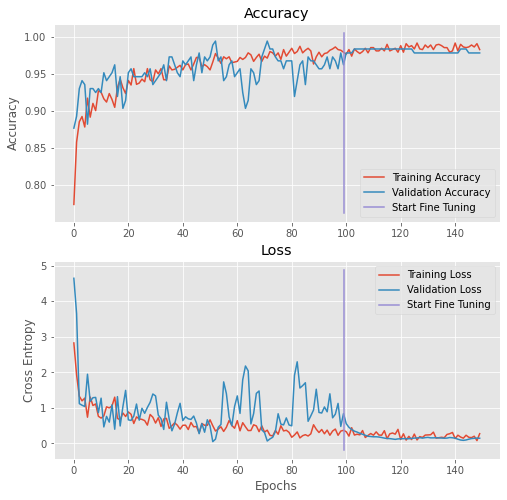

In [34]:
acc += train_history.history['accuracy']
val_acc += train_history.history['val_accuracy']

loss += train_history.history['loss']
val_loss += train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot2.pdf")
plt.show()

In [35]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 1.1004 - accuracy: 0.9688

2/5 [===========>..................] - ETA: 2s - loss: 1.2587 - accuracy: 0.9531

3/5 [=================>............] - ETA: 2s - loss: 0.9286 - accuracy: 0.9609

4/5 [=======================>......] - ETA: 1s - loss: 0.8074 - accuracy: 0.9668

5/5 [==============================] - ETA: 0s - loss: 0.7476 - accuracy: 0.9664

5/5 [==============================] - 6s 1s/step - loss: 0.7476 - accuracy: 0.9664


[0.7476311922073364, 0.9664310812950134]

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = new_model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
y_probas = y_pred
y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
print('Accuracy: ', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy:  0.9664310954063604
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       164
           1       0.98      0.97      0.98       402

    accuracy                           0.97       566
   macro avg       0.95      0.97      0.96       566
weighted avg       0.97      0.97      0.97       566



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

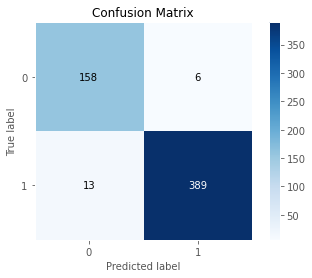

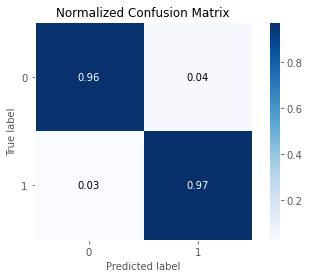

In [38]:
plot_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, normalize=True)

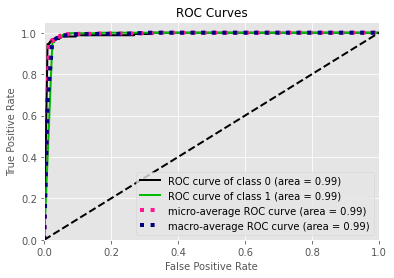

In [39]:
plot_roc(y_true, y_probas)

In [40]:
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [41]:
print(classification_report(y_true, y_pred))
print(classification_report_imbalanced(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       164
           1       0.98      0.97      0.98       402

    accuracy                           0.97       566
   macro avg       0.95      0.97      0.96       566
weighted avg       0.97      0.97      0.97       566

                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.96      0.97      0.94      0.97      0.93       164
          1       0.98      0.97      0.96      0.98      0.97      0.93       402

avg / total       0.97      0.97      0.96      0.97      0.97      0.93       566

